In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

%matplotlib inline: 이 라인은 Jupyter Notebook에서 matplotlib 그래프를 인라인으로 표시하도록 지정합니다. 이는 그래프가 코드 셀 아래에 바로 나타나게 하는 명령입니다.

%config InlineBackend.figure_format = "retina": 이 라인은 그래프의 해상도를 개선하기 위해 "retina" 해상도를 사용하도록 지정합니다. 특히, Retina 디스플레이를 갖춘 장치에서는 고해상도 그래픽을 지원합니다.

register_matplotlib_converters(): 이 라인은 날짜와 관련된 데이터를 다룰 때 matplotlib이 제대로 작동하도록 하는 등록 작업을 수행합니다.

sns.set(style="whitegrid", palette="muted", font_scale=1.5): Seaborn 라이브러리를 사용하여 시각화의 기본 스타일을 설정합니다. whitegrid는 흰 배경에 격자 라인이 있는 스타일을 사용하도록 설정하고, muted는 부드러운 색상 팔레트를 사용하도록 지정합니다. font_scale=1.5는 글꼴 크기를 1.5배로 설정합니다.

rcParams["figure.figsize"] = 22, 10: matplotlib의 rcParams를 사용하여 기본적인 그림 크기를 설정합니다. figure.figsize는 가로와 세로 크기를 나타내며, 여기서는 (22, 10)으로 설정되어 있습니다.

In [31]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [32]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [33]:
df.head()

user_id activity       timestamp    x_axis     y_axis    z_axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [35]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098198       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098199       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098200       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098201       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098202       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098198                4  
1098199                4  
1098200                4  
1098201                4  
1098202                4  

[1098203 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

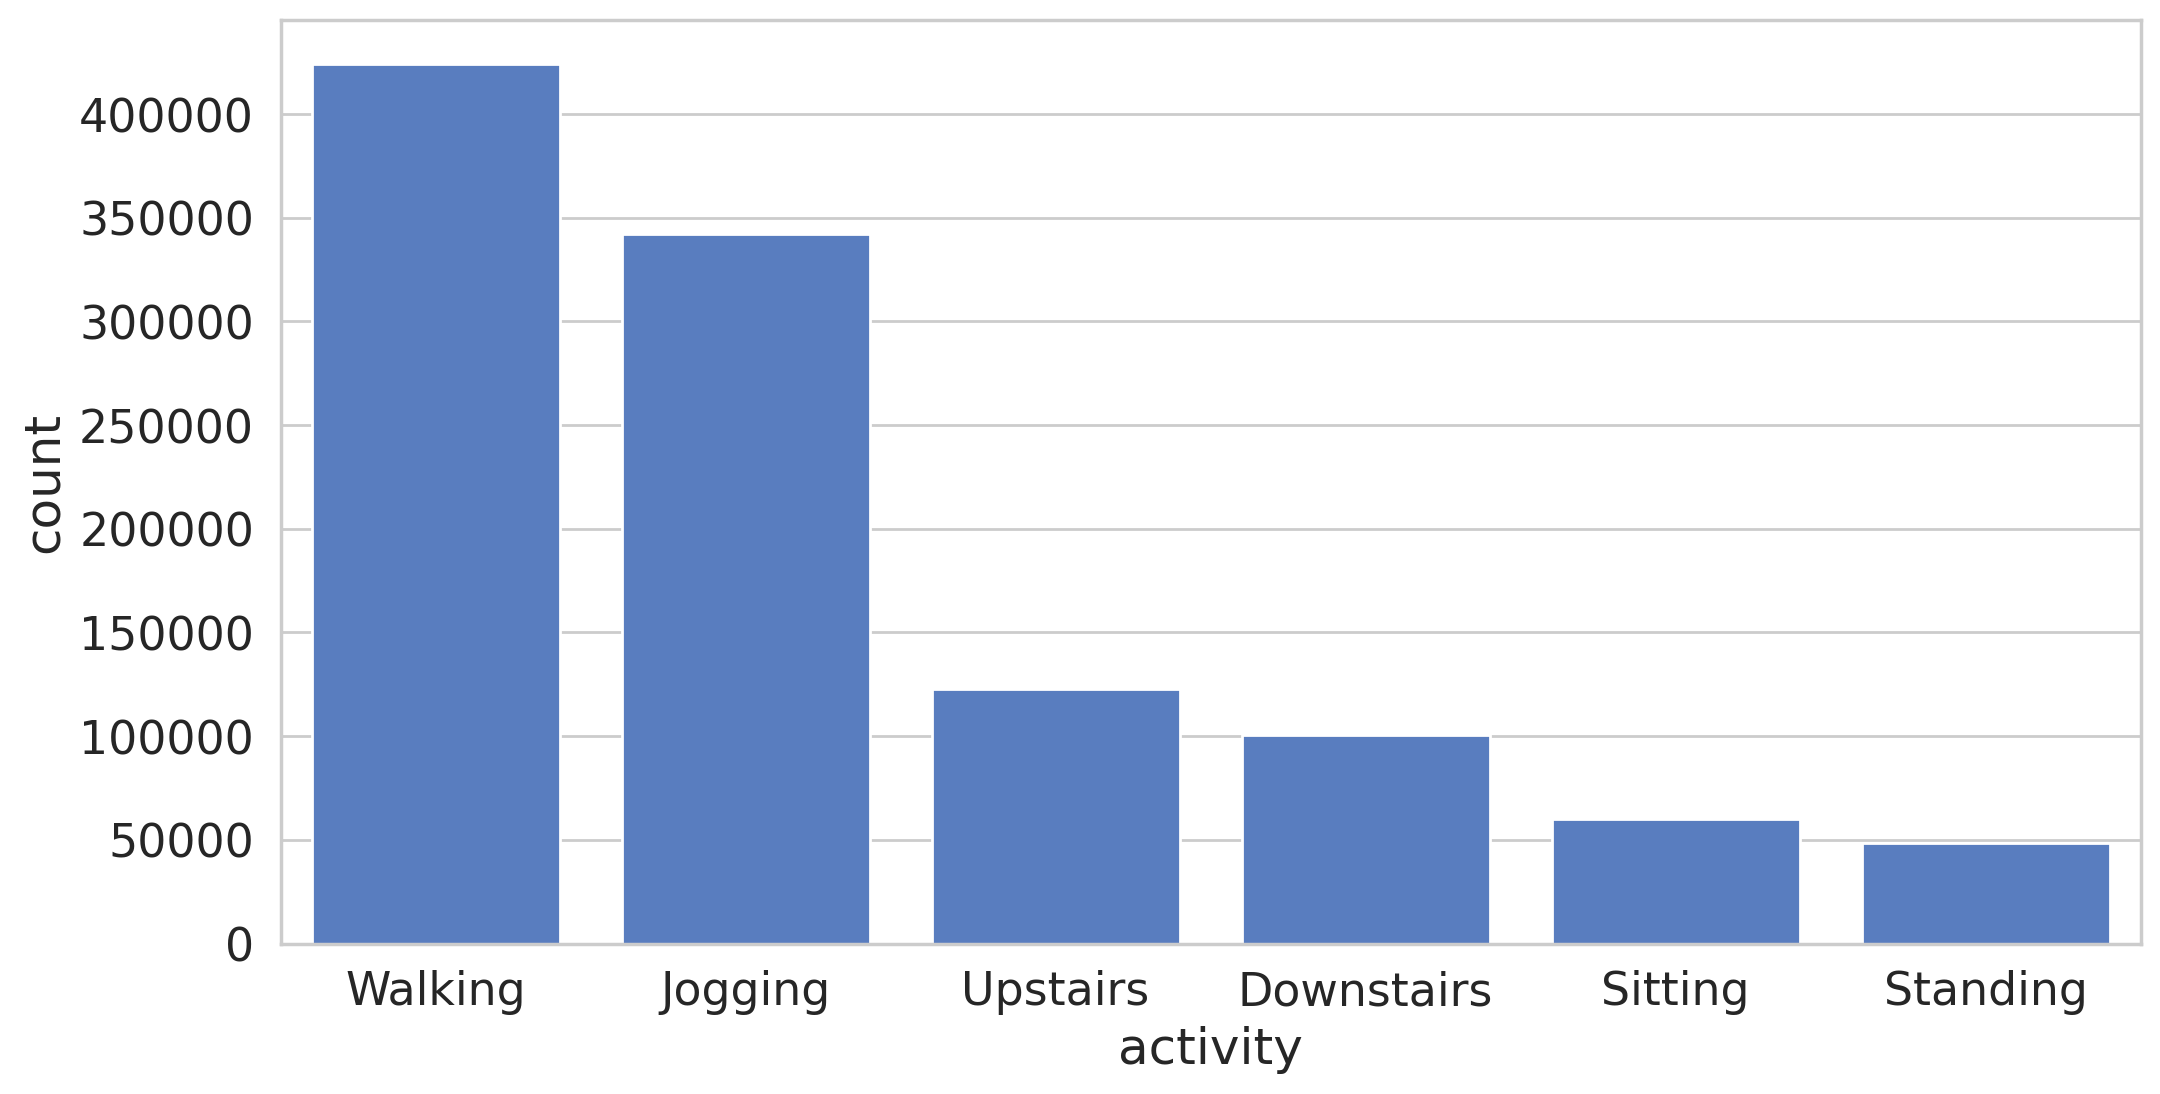

In [42]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

<ipython-input-43-5a2bc0c33510>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
<ipython-input-43-5a2bc0c33510>:1: UserWarning: 
The palette list has fewer values (1) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],


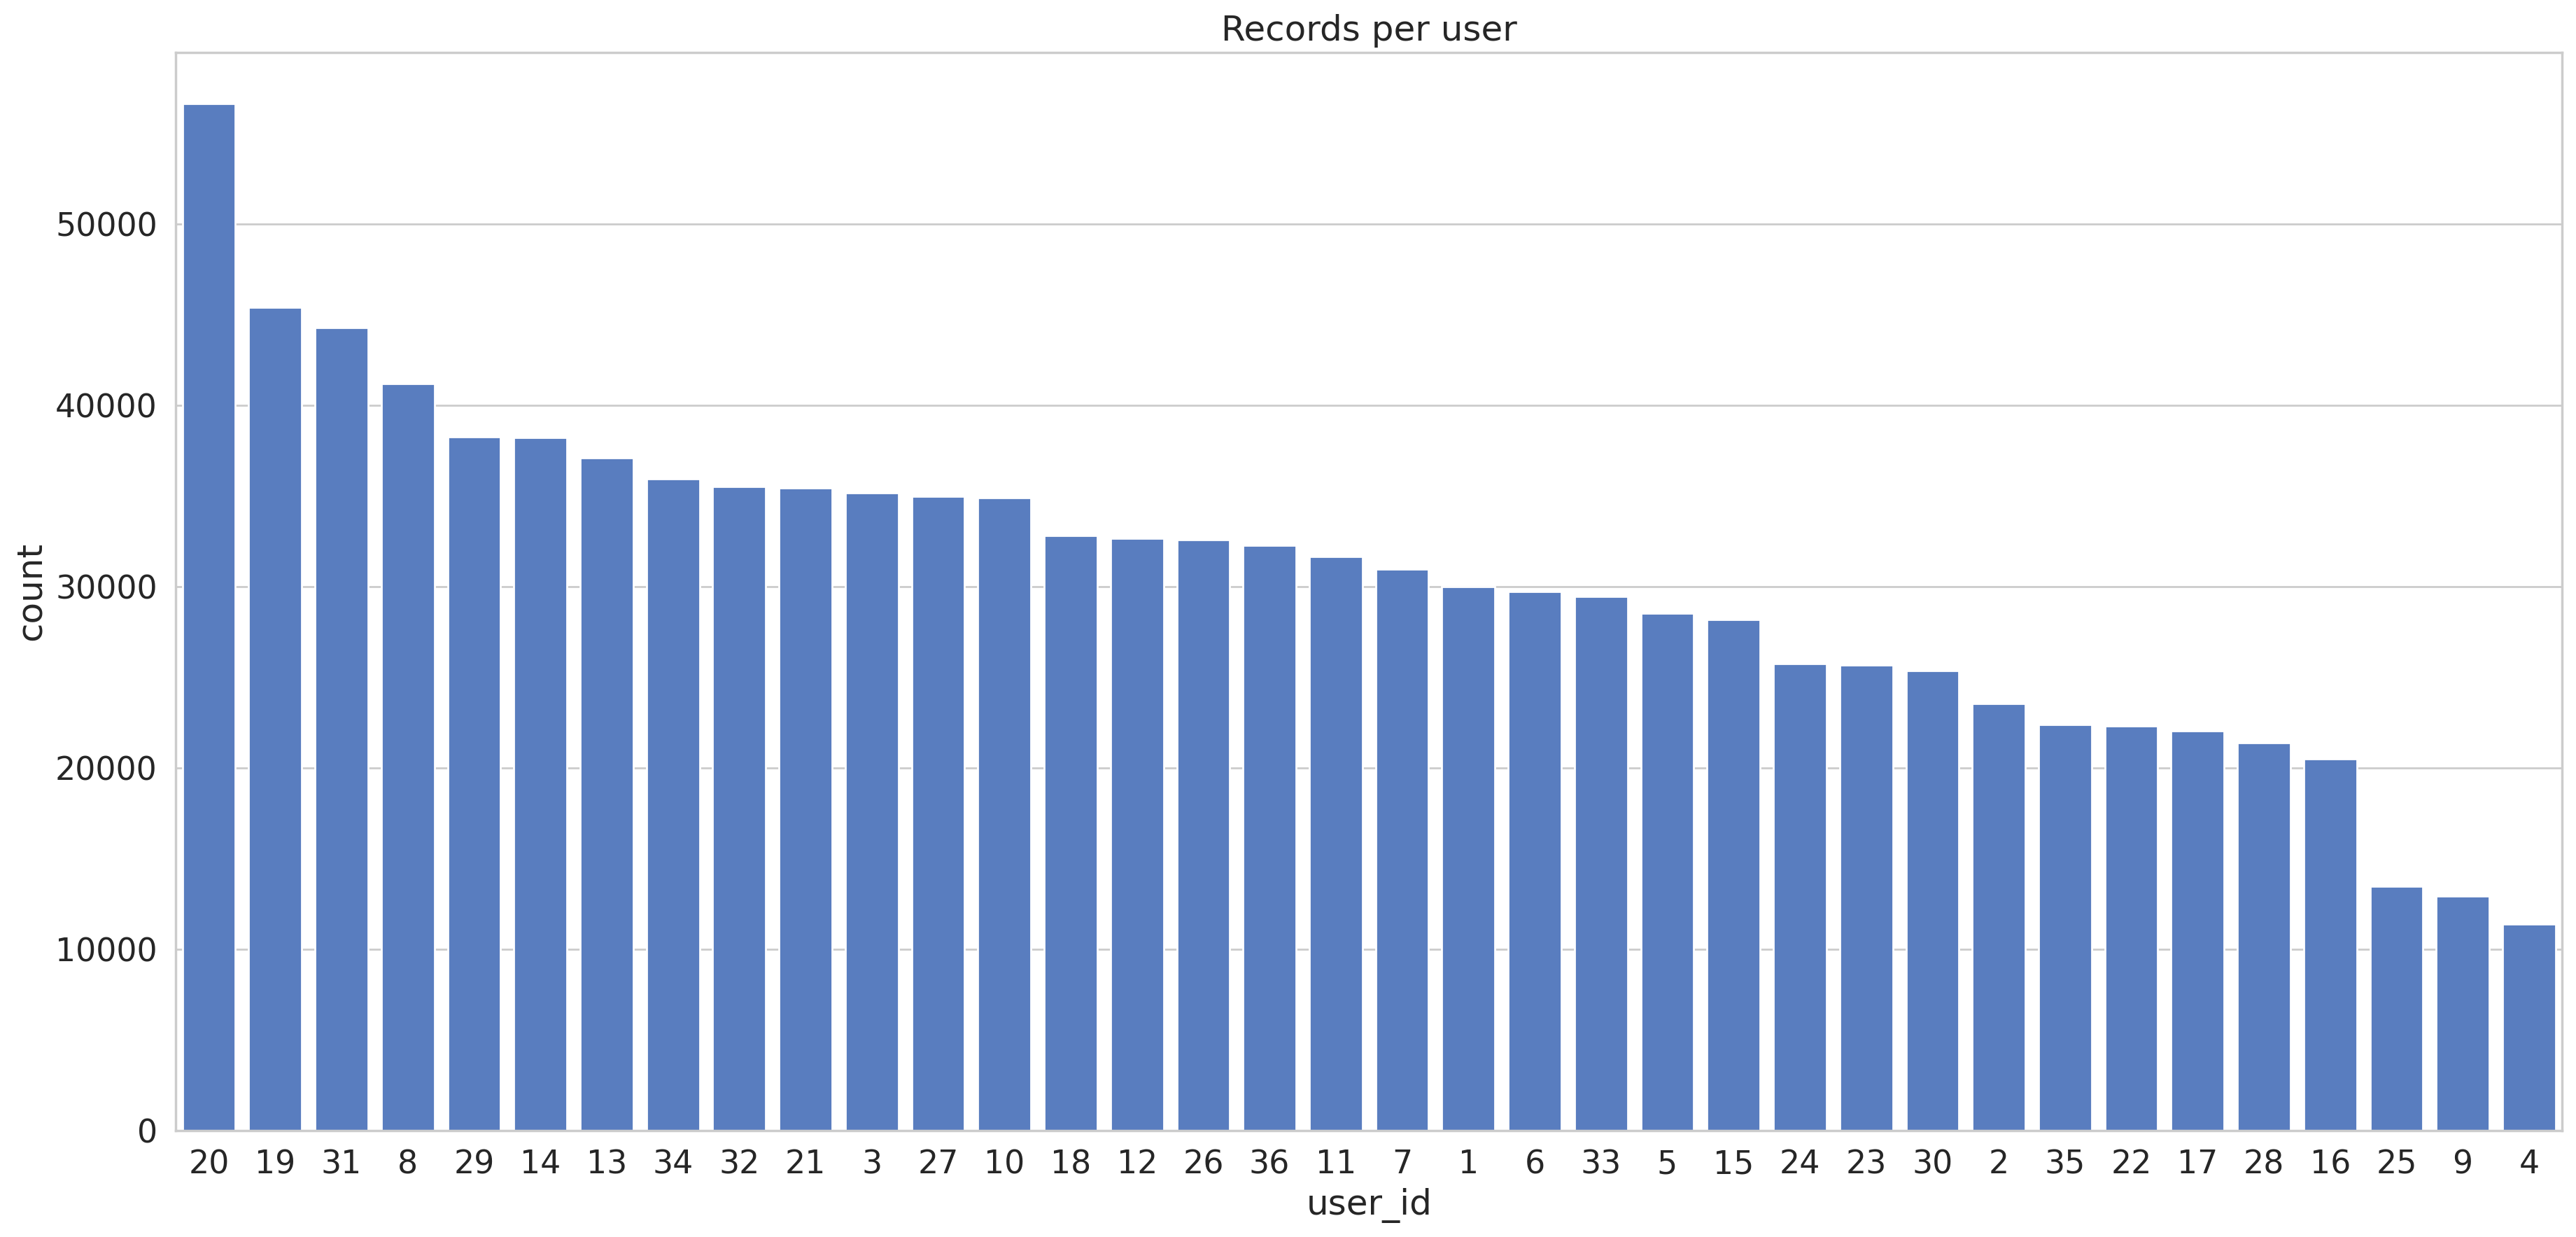

In [43]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");

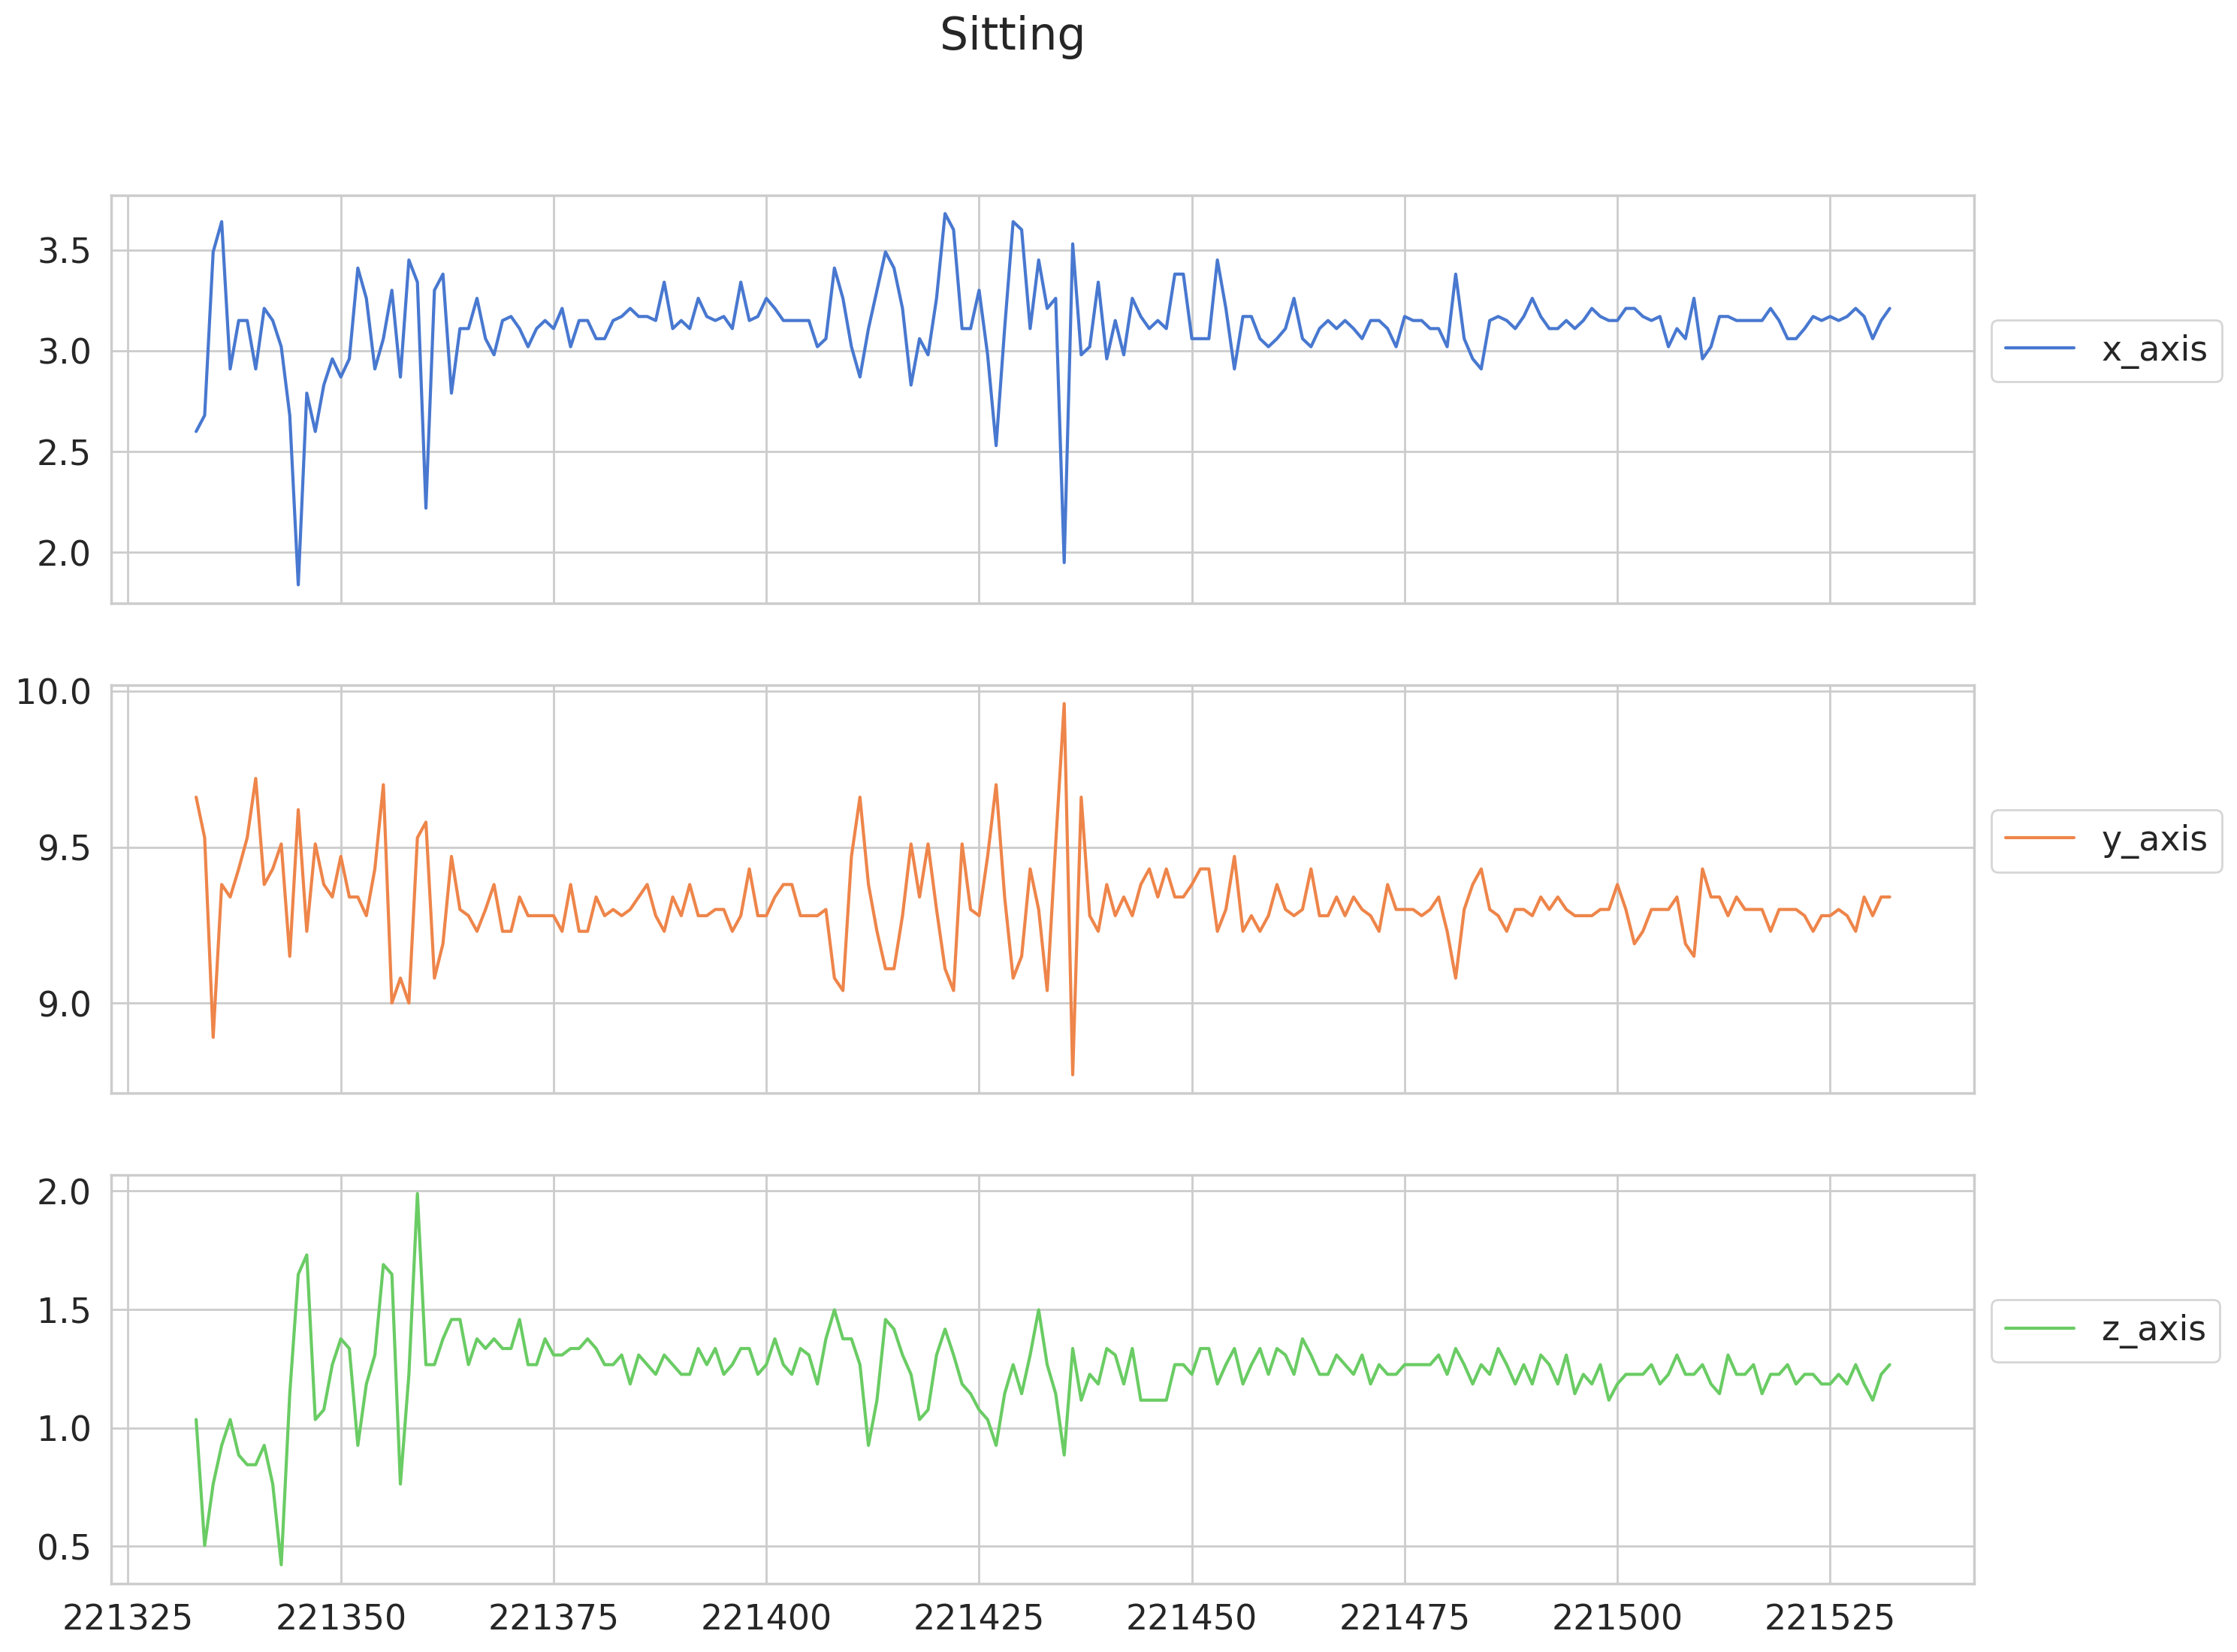

In [44]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)

In [45]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.131961  0.566215  0.102015   
1             33  Jogging   49106062271000  0.648740  0.397381  0.193001   
2             33  Jogging   49106112167000  0.633834  0.351926 -0.016543   
3             33  Jogging   49106222305000 -0.120782  1.259408  0.612089   
4             33  Jogging   49106332290000 -0.199038  0.498032  1.458535   
...          ...      ...              ...       ...       ...       ...   
1098198       19  Sitting  131623331483000  1.194254 -1.132300  0.342105   
1098199       19  Sitting  131623371431000  1.199726 -1.119190  0.350202   
1098200       19  Sitting  131623411592000  1.205198 -1.109654  0.342105   
1098201       19  Sitting  131623491487000  1.194254 -1.119190  0.350202   
1098202       19  Sitting  131623531465000  1.177839 -1.103695  0.325911   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098198                4  
1098199                4  
1098200                4  
1098201                4  
1098202                4  

[1098203 rows x 7 columns]

In [46]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17568, 200, 3) (17568, 1)
(5491, 200, 3) (5491, 1)


In [47]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17568, 200, 3) (17568, 6) (5491, 200, 3) (5491, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [48]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 6)

In [49]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 128)               1622144   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1623558 (6.19 MB)
Trainable params: 1623558 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 20s 135ms/step - loss: 0.7474 - accuracy: 0.7349 - val_loss: 0.4670 - val_accuracy: 0.8258
Epoch 2/10
138/138 [==============================] - 14s 100ms/step - loss: 0.3943 - accuracy: 0.8517 - val_loss: 0.3620 - val_accuracy: 0.8593
Epoch 3/10
138/138 [==============================] - 8s 59ms/step - loss: 0.2860 - accuracy: 0.8928 - val_loss: 0.3354 - val_accuracy: 0.8725
Epoch 4/10
138/138 [==============================] - 9s 68ms/step - loss: 0.2142 - accuracy: 0.9240 - val_loss: 0.3131 - val_accuracy: 0.8855
Epoch 5/10
138/138 [==============================] - 9s 63ms/step - loss: 0.1610 - accuracy: 0.9455 - val_loss: 0.3188 - val_accuracy: 0.8912
Epoch 6/10
138/138 [==============================] - 8s 61ms/step - loss: 0.1272 - accuracy: 0.9583 - val_loss: 0.2902 - val_accuracy: 0.8944
Epoch 7/10
138/138 [==============================] - 10s 70ms/step - loss: 0.0905 - accuracy: 0.9733 - val_loss: 0.3084 - val_accuracy: 0

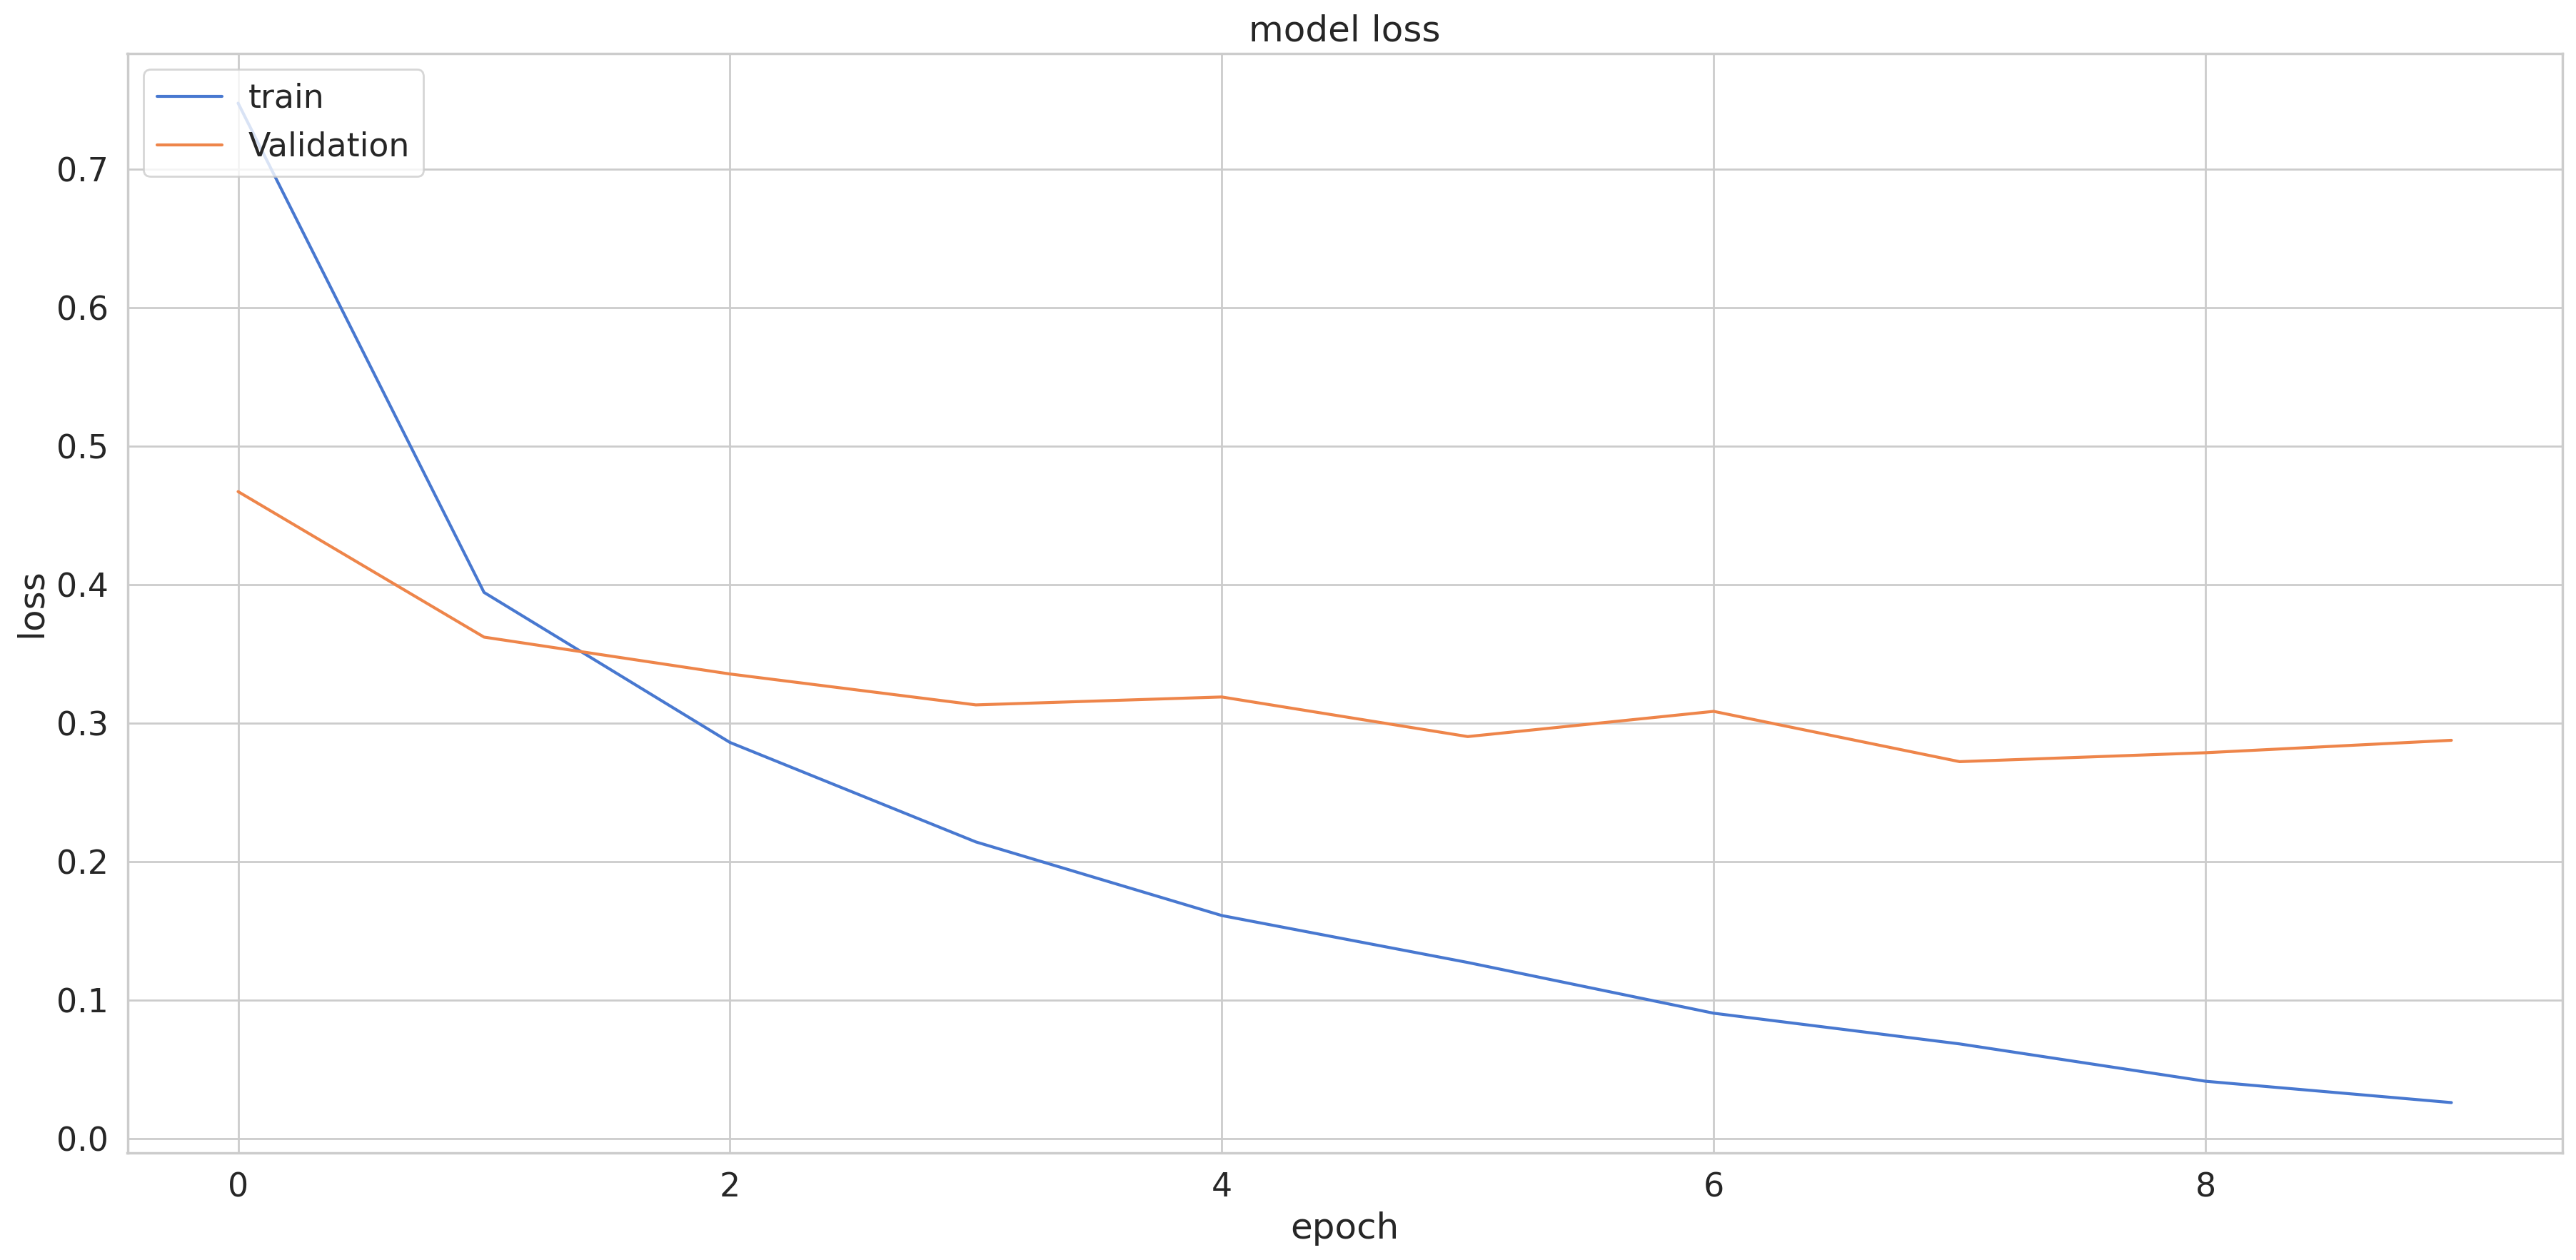

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

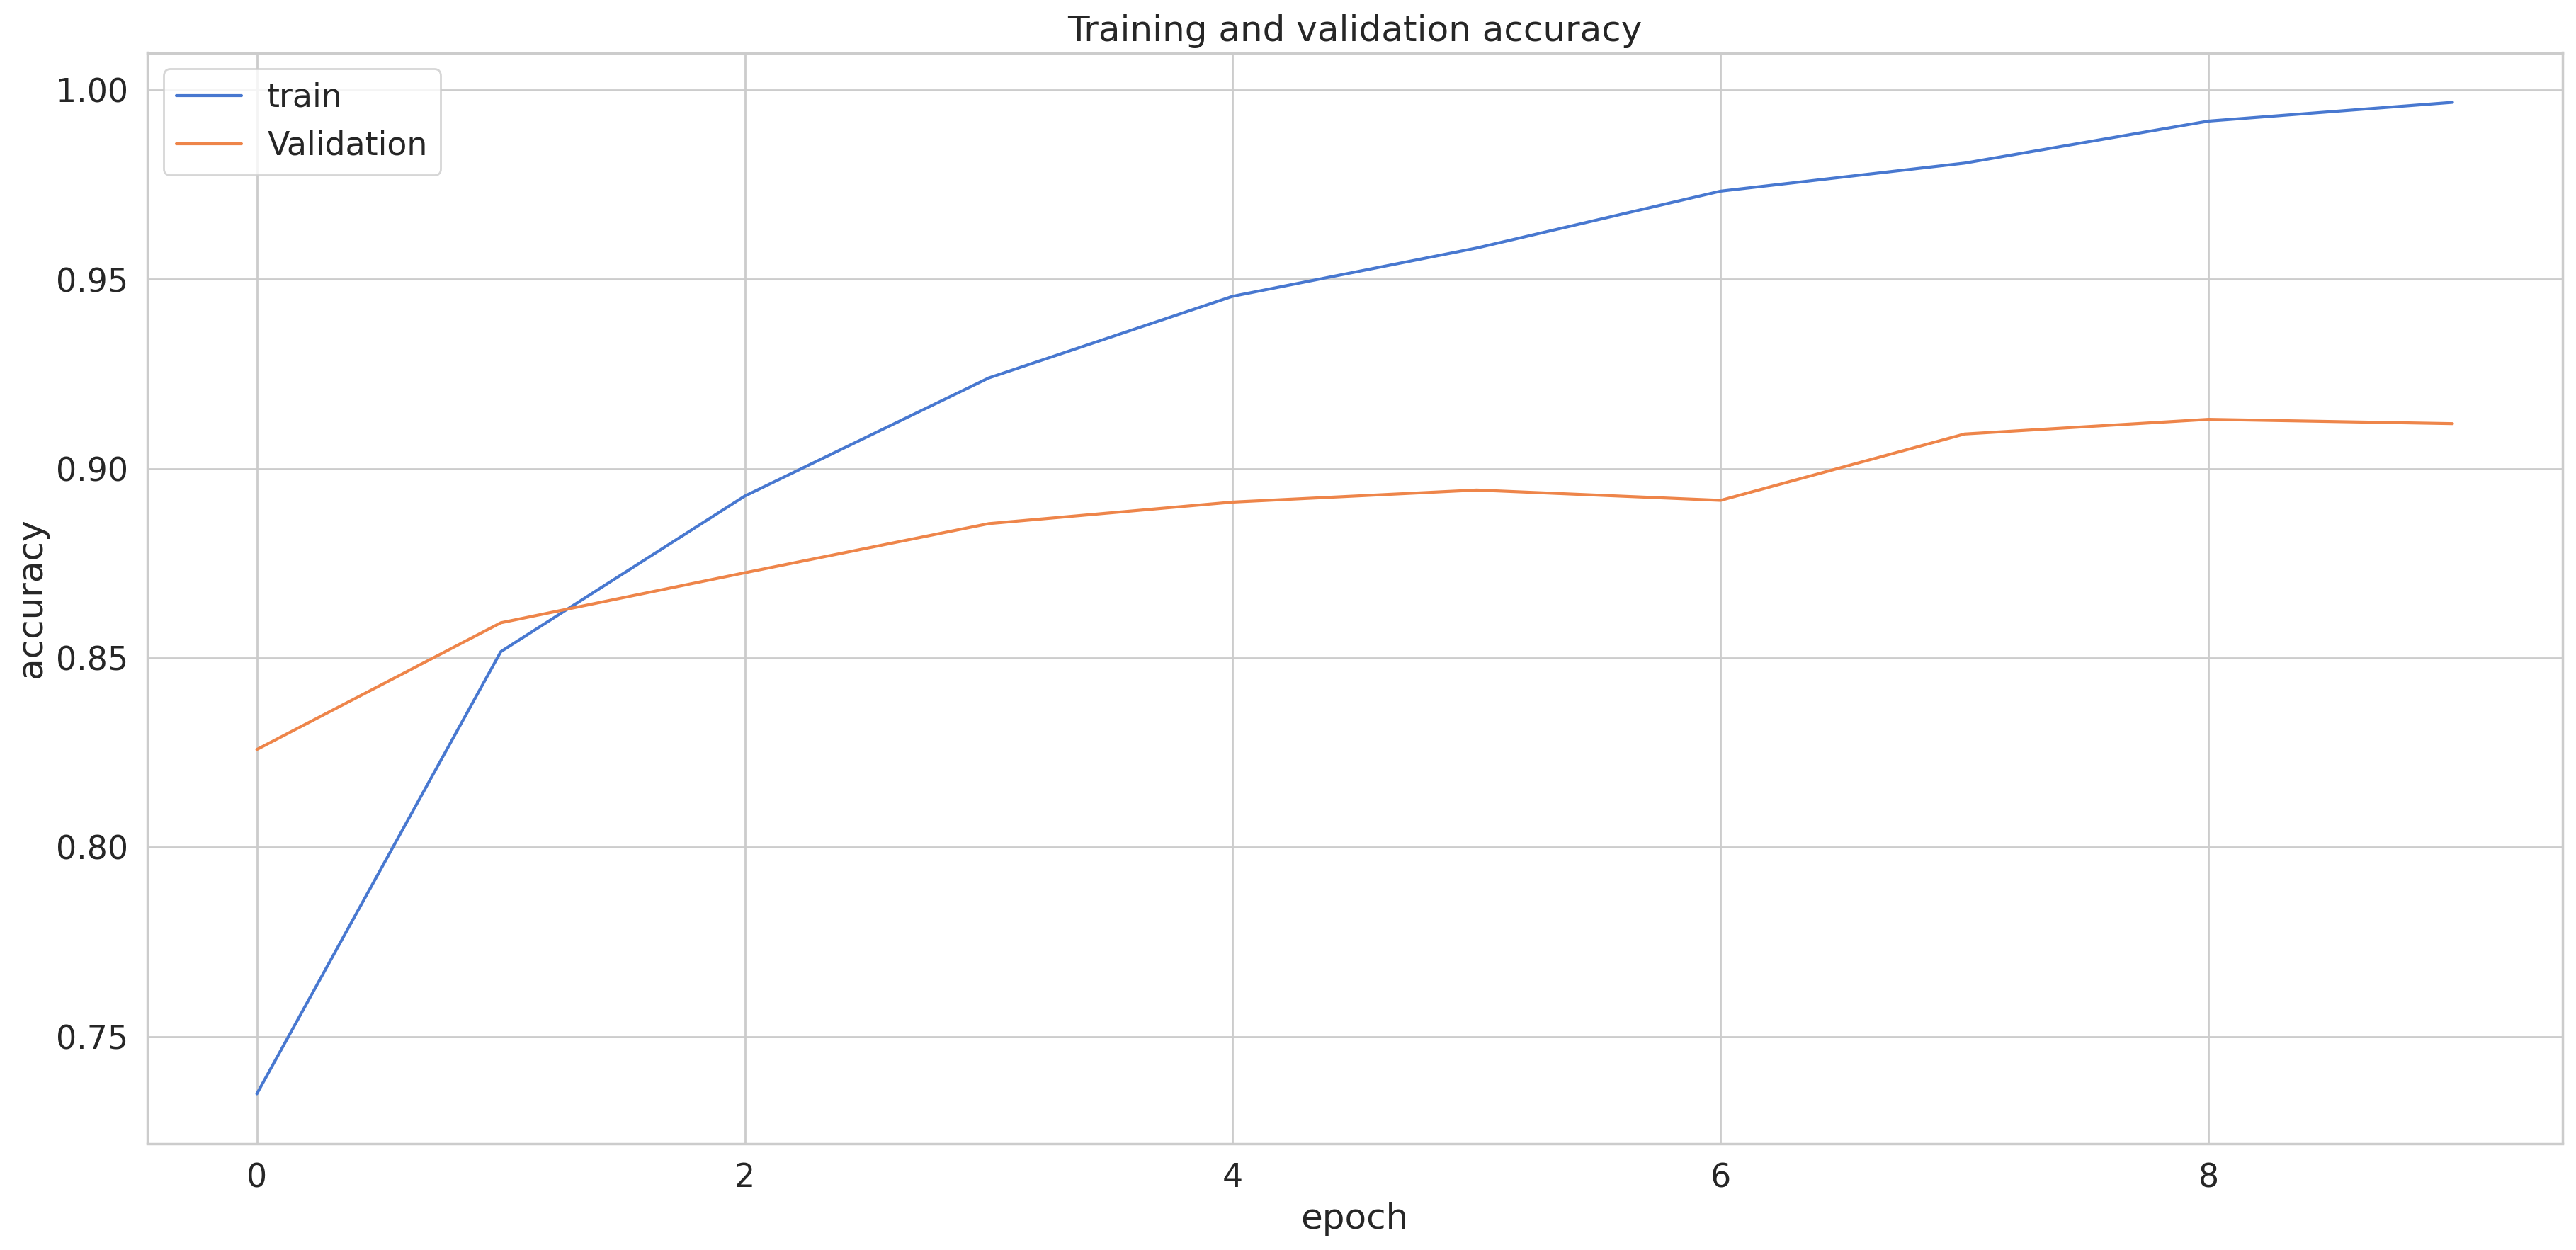

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 1s 6ms/step
f1_score =  0.9148791423893512
0.9153159715898743
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2123
           1       0.96      0.98      0.97      1710
           2       0.73      0.75      0.74       614
           3       0.70      0.67      0.68       502
           4       1.00      1.00      1.00       300
           5       1.00      0.97      0.98       242

    accuracy                           0.92      5491
   macro avg       0.89      0.89      0.89      5491
weighted avg       0.91      0.92      0.91      5491



<Axes: >

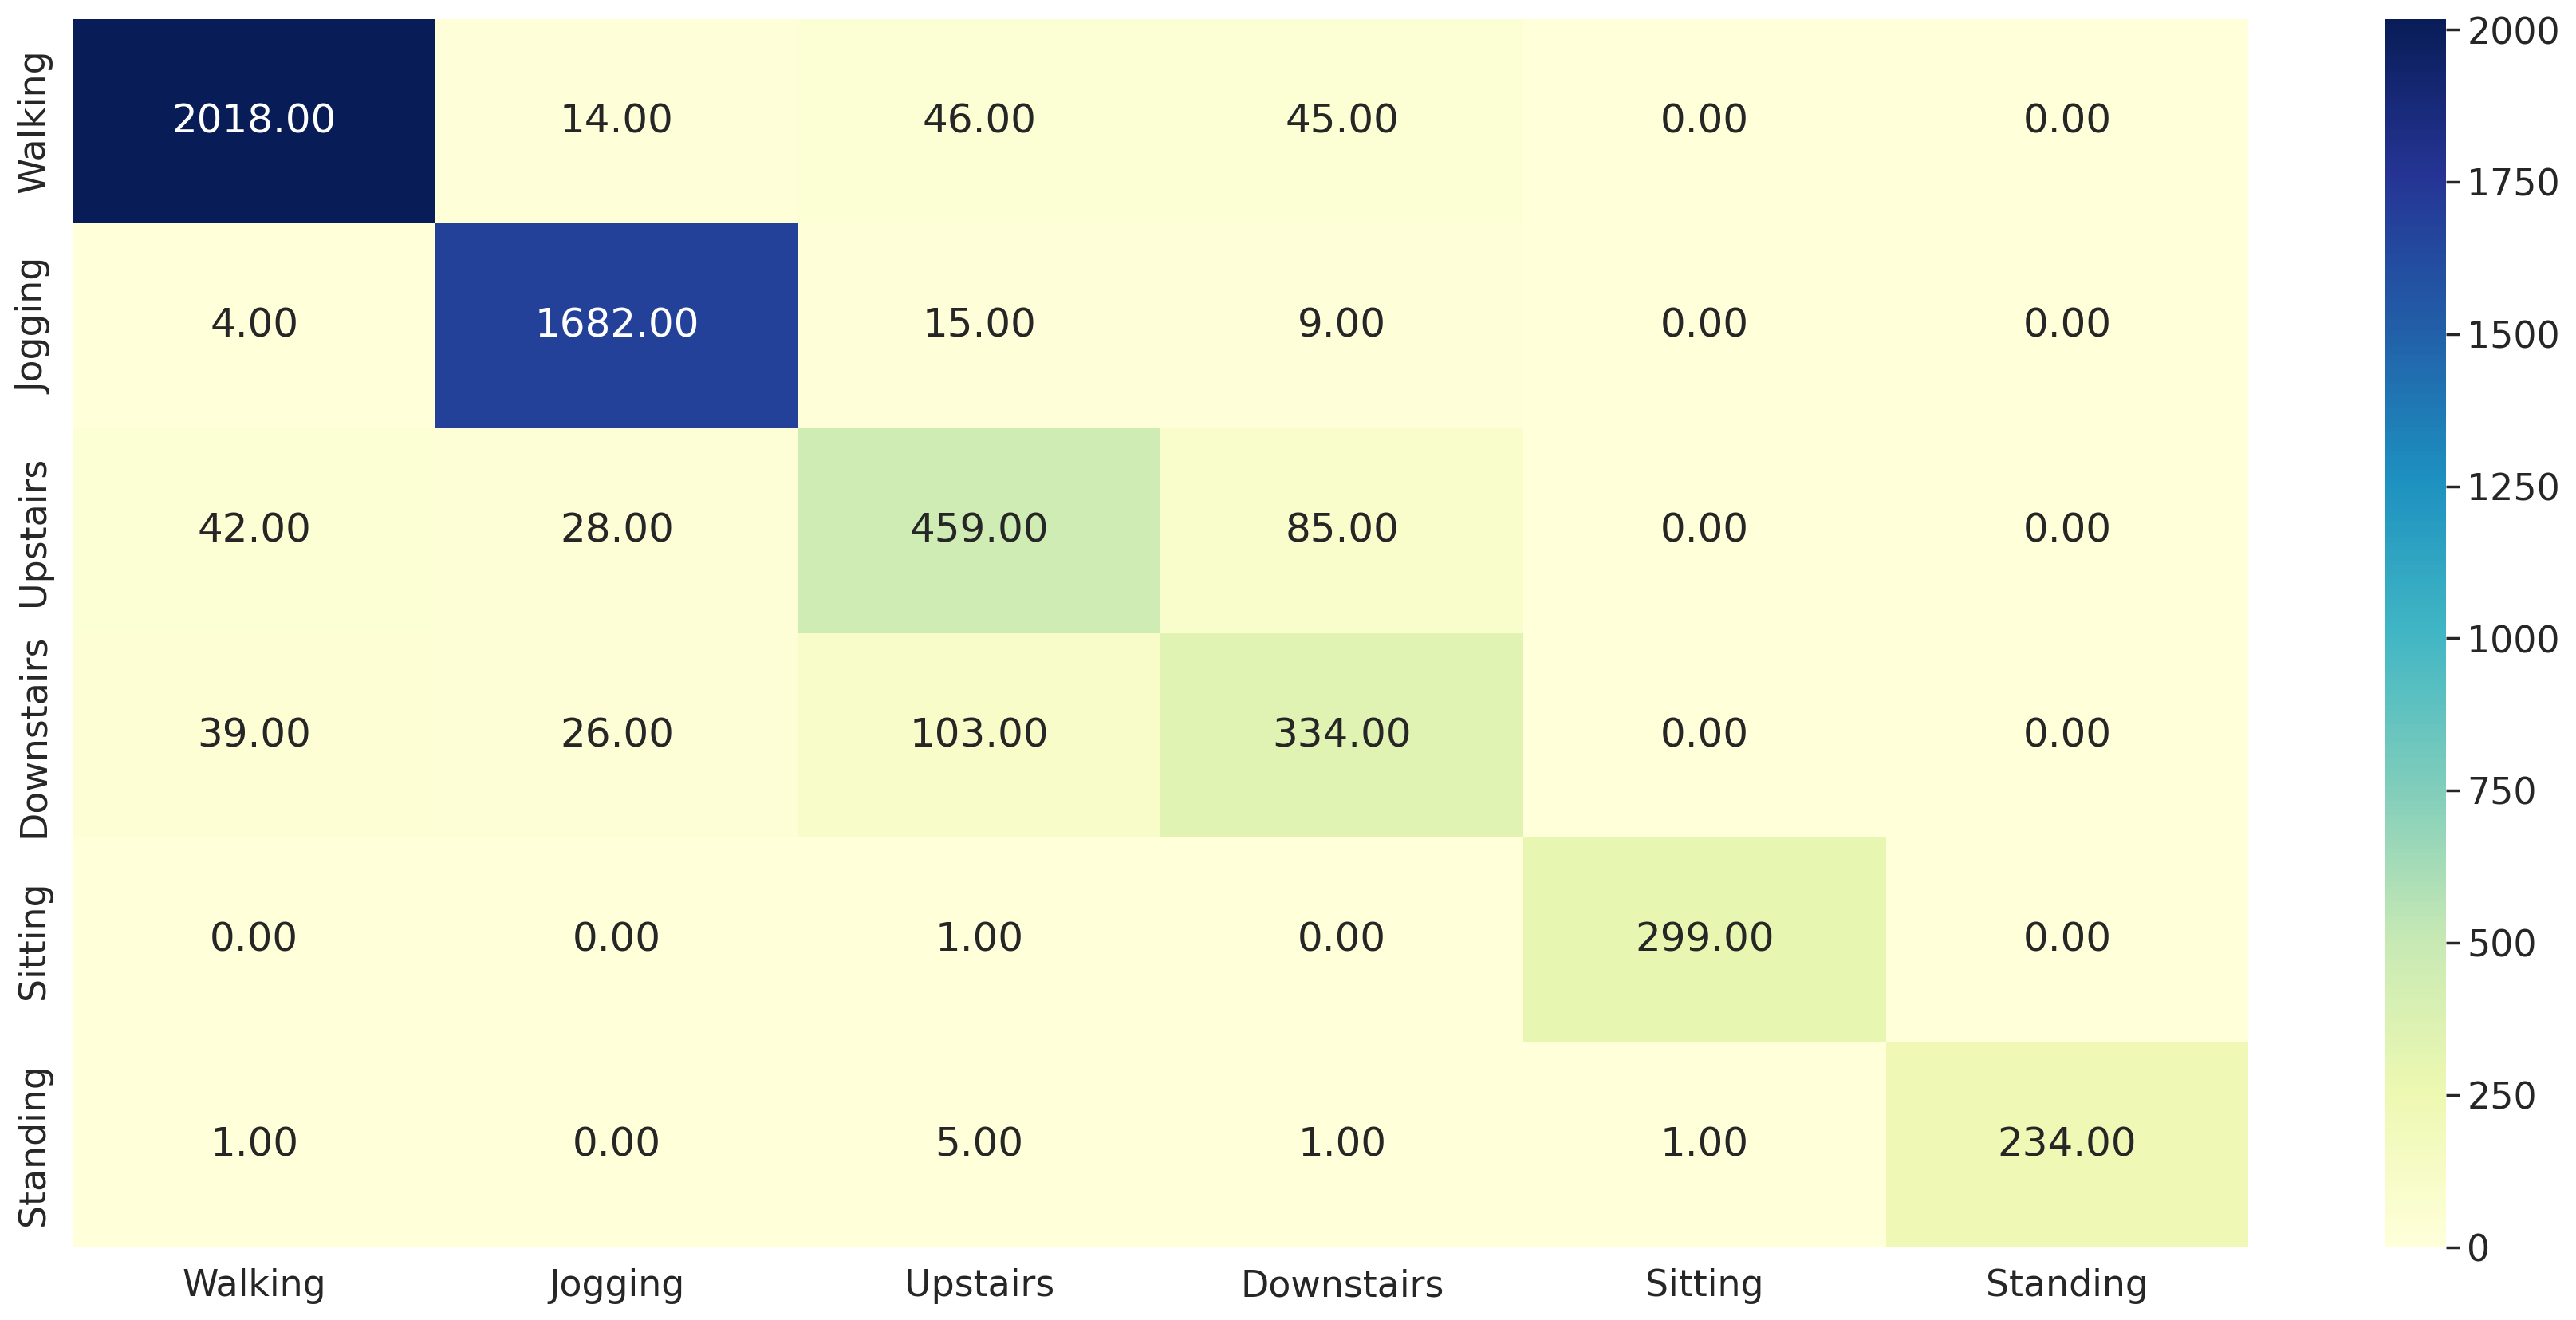

In [53]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 2</h1>

In [54]:
# Model 2
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1605760   
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1619526 (6.18 MB)
Trainable params: 1619526 (6.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 17s 114ms/step - loss: 0.6011 - accuracy: 0.7735 - val_loss: 0.3565 - val_accuracy: 0.8641
Epoch 2/10
138/138 [==============================] - 17s 126ms/step - loss: 0.2400 - accuracy: 0.9123 - val_loss: 0.2321 - val_accuracy: 0.9094
Epoch 3/10
138/138 [==============================] - 16s 114ms/step - loss: 0.1446 - accuracy: 0.9525 - val_loss: 0.1759 - val_accuracy: 0.9422
Epoch 4/10
138/138 [==============================] - 15s 112ms/step - loss: 0.0861 - accuracy: 0.9740 - val_loss: 0.1560 - val_accuracy: 0.9454
Epoch 5/10
138/138 [==============================] - 16s 113ms/step - loss: 0.0578 - accuracy: 0.9834 - val_loss: 0.1689 - val_accuracy: 0.9447
Epoch 6/10
138/138 [==============================] - 16s 114ms/step - loss: 0.0344 - accuracy: 0.9915 - val_loss: 0.1404 - val_accuracy: 0.9558
Epoch 7/10
138/138 [==============================] - 15s 112ms/step - loss: 0.0173 - accuracy: 0.9965 - val_loss: 0.1471 - val_ac

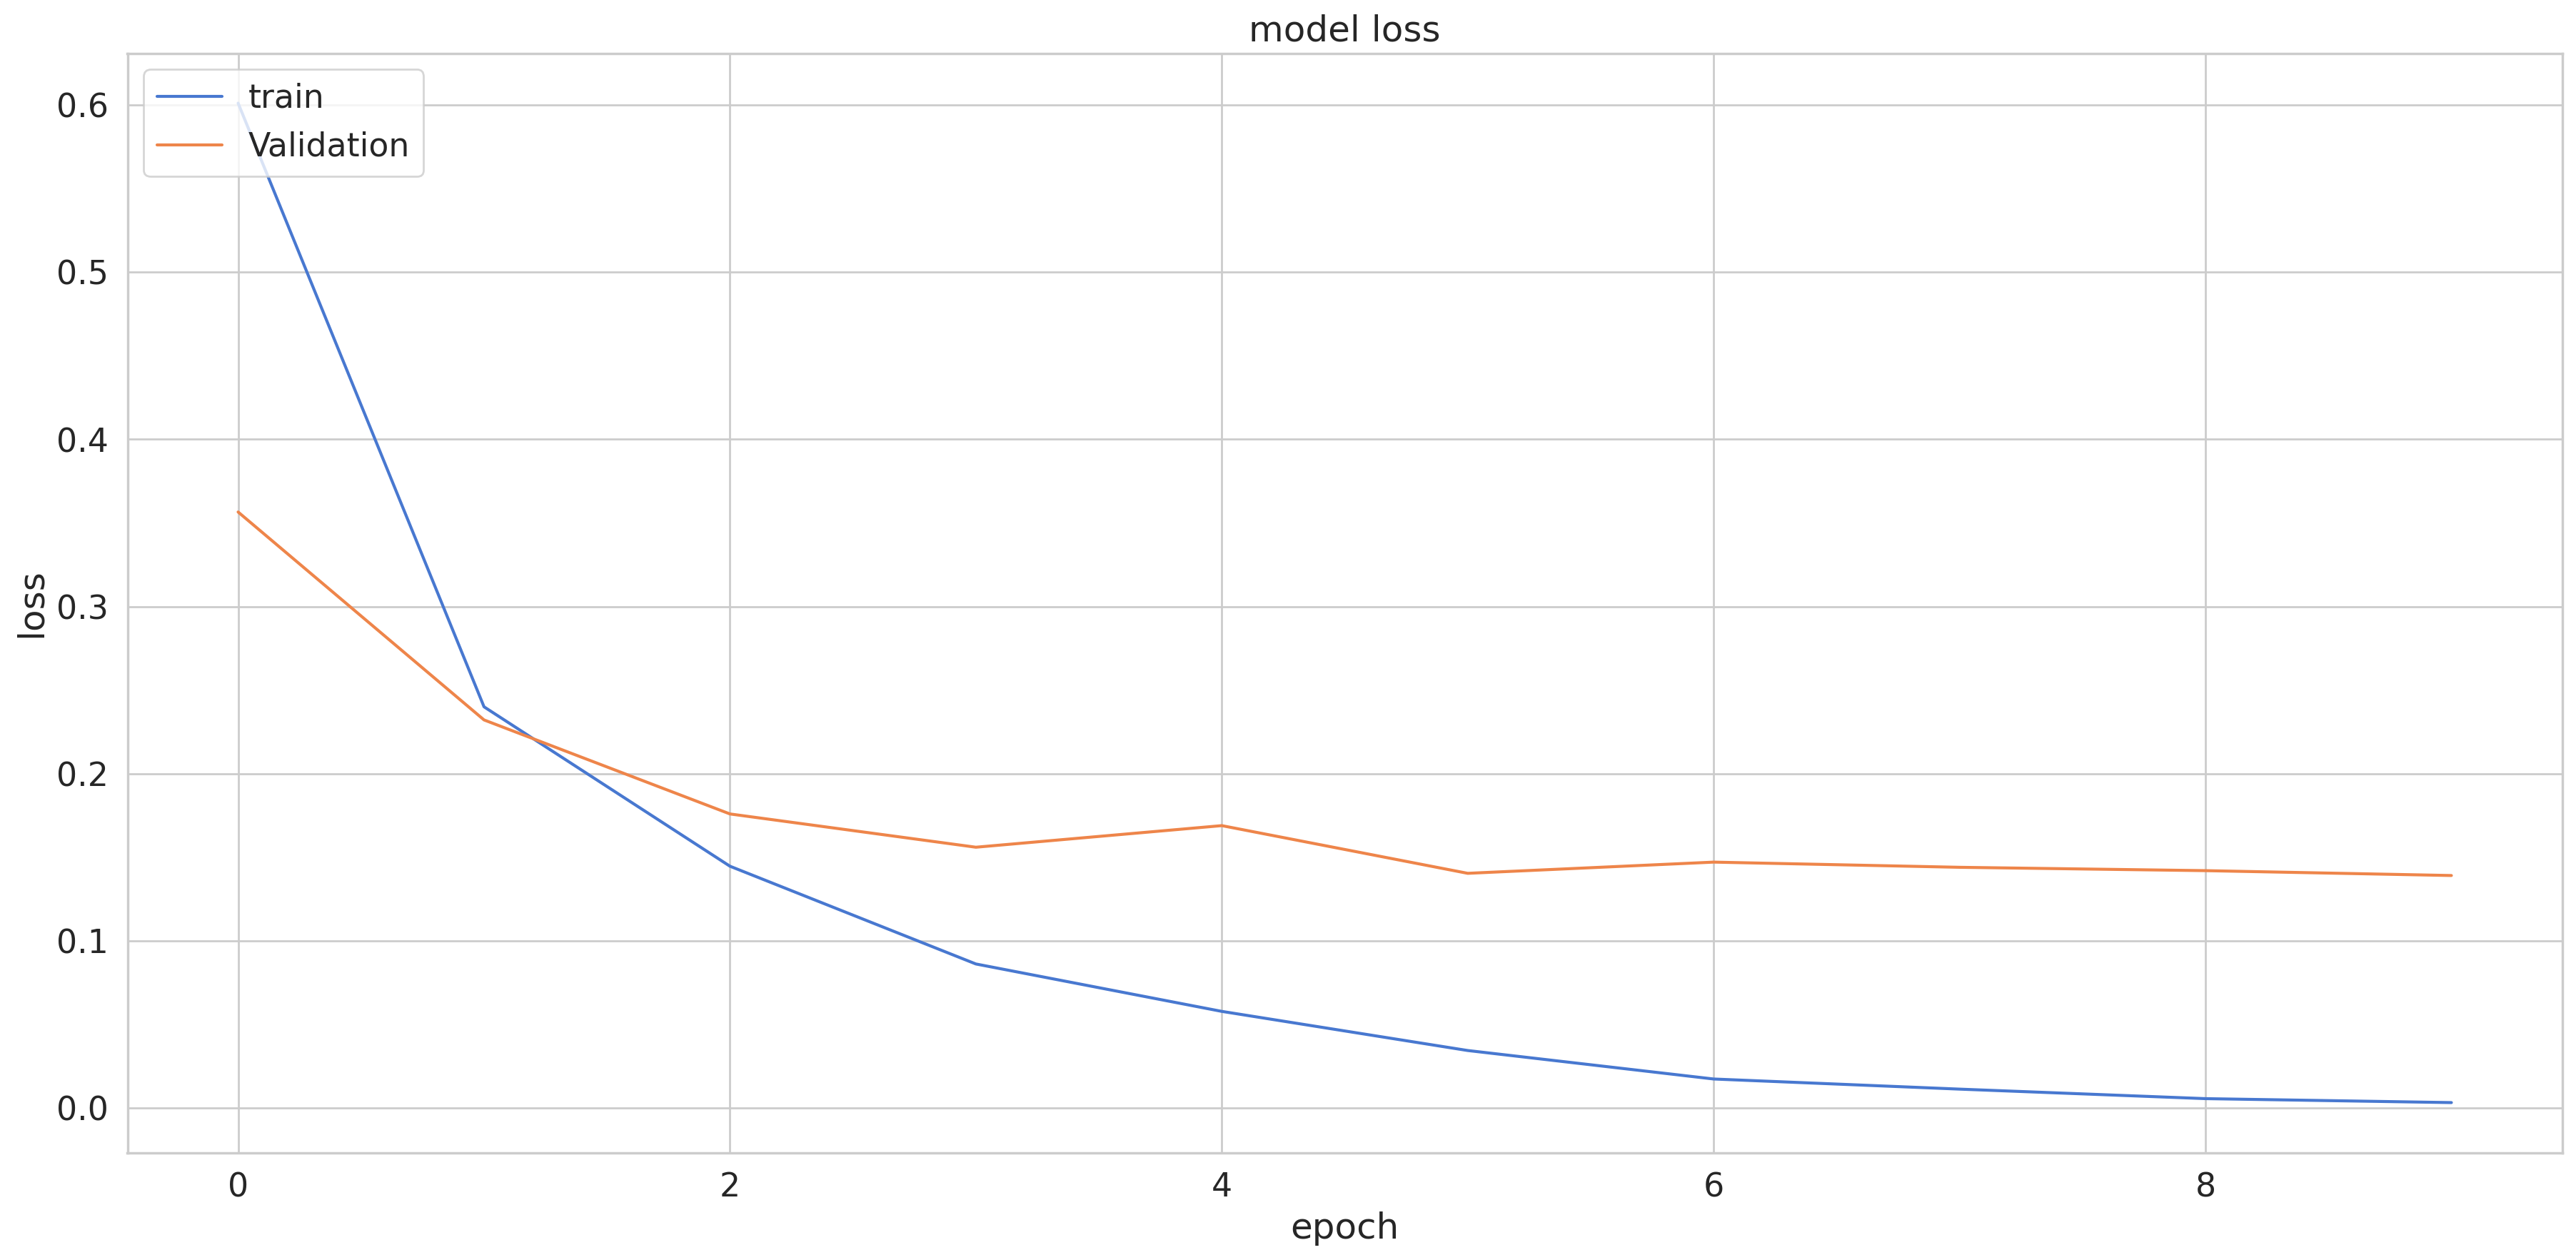

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

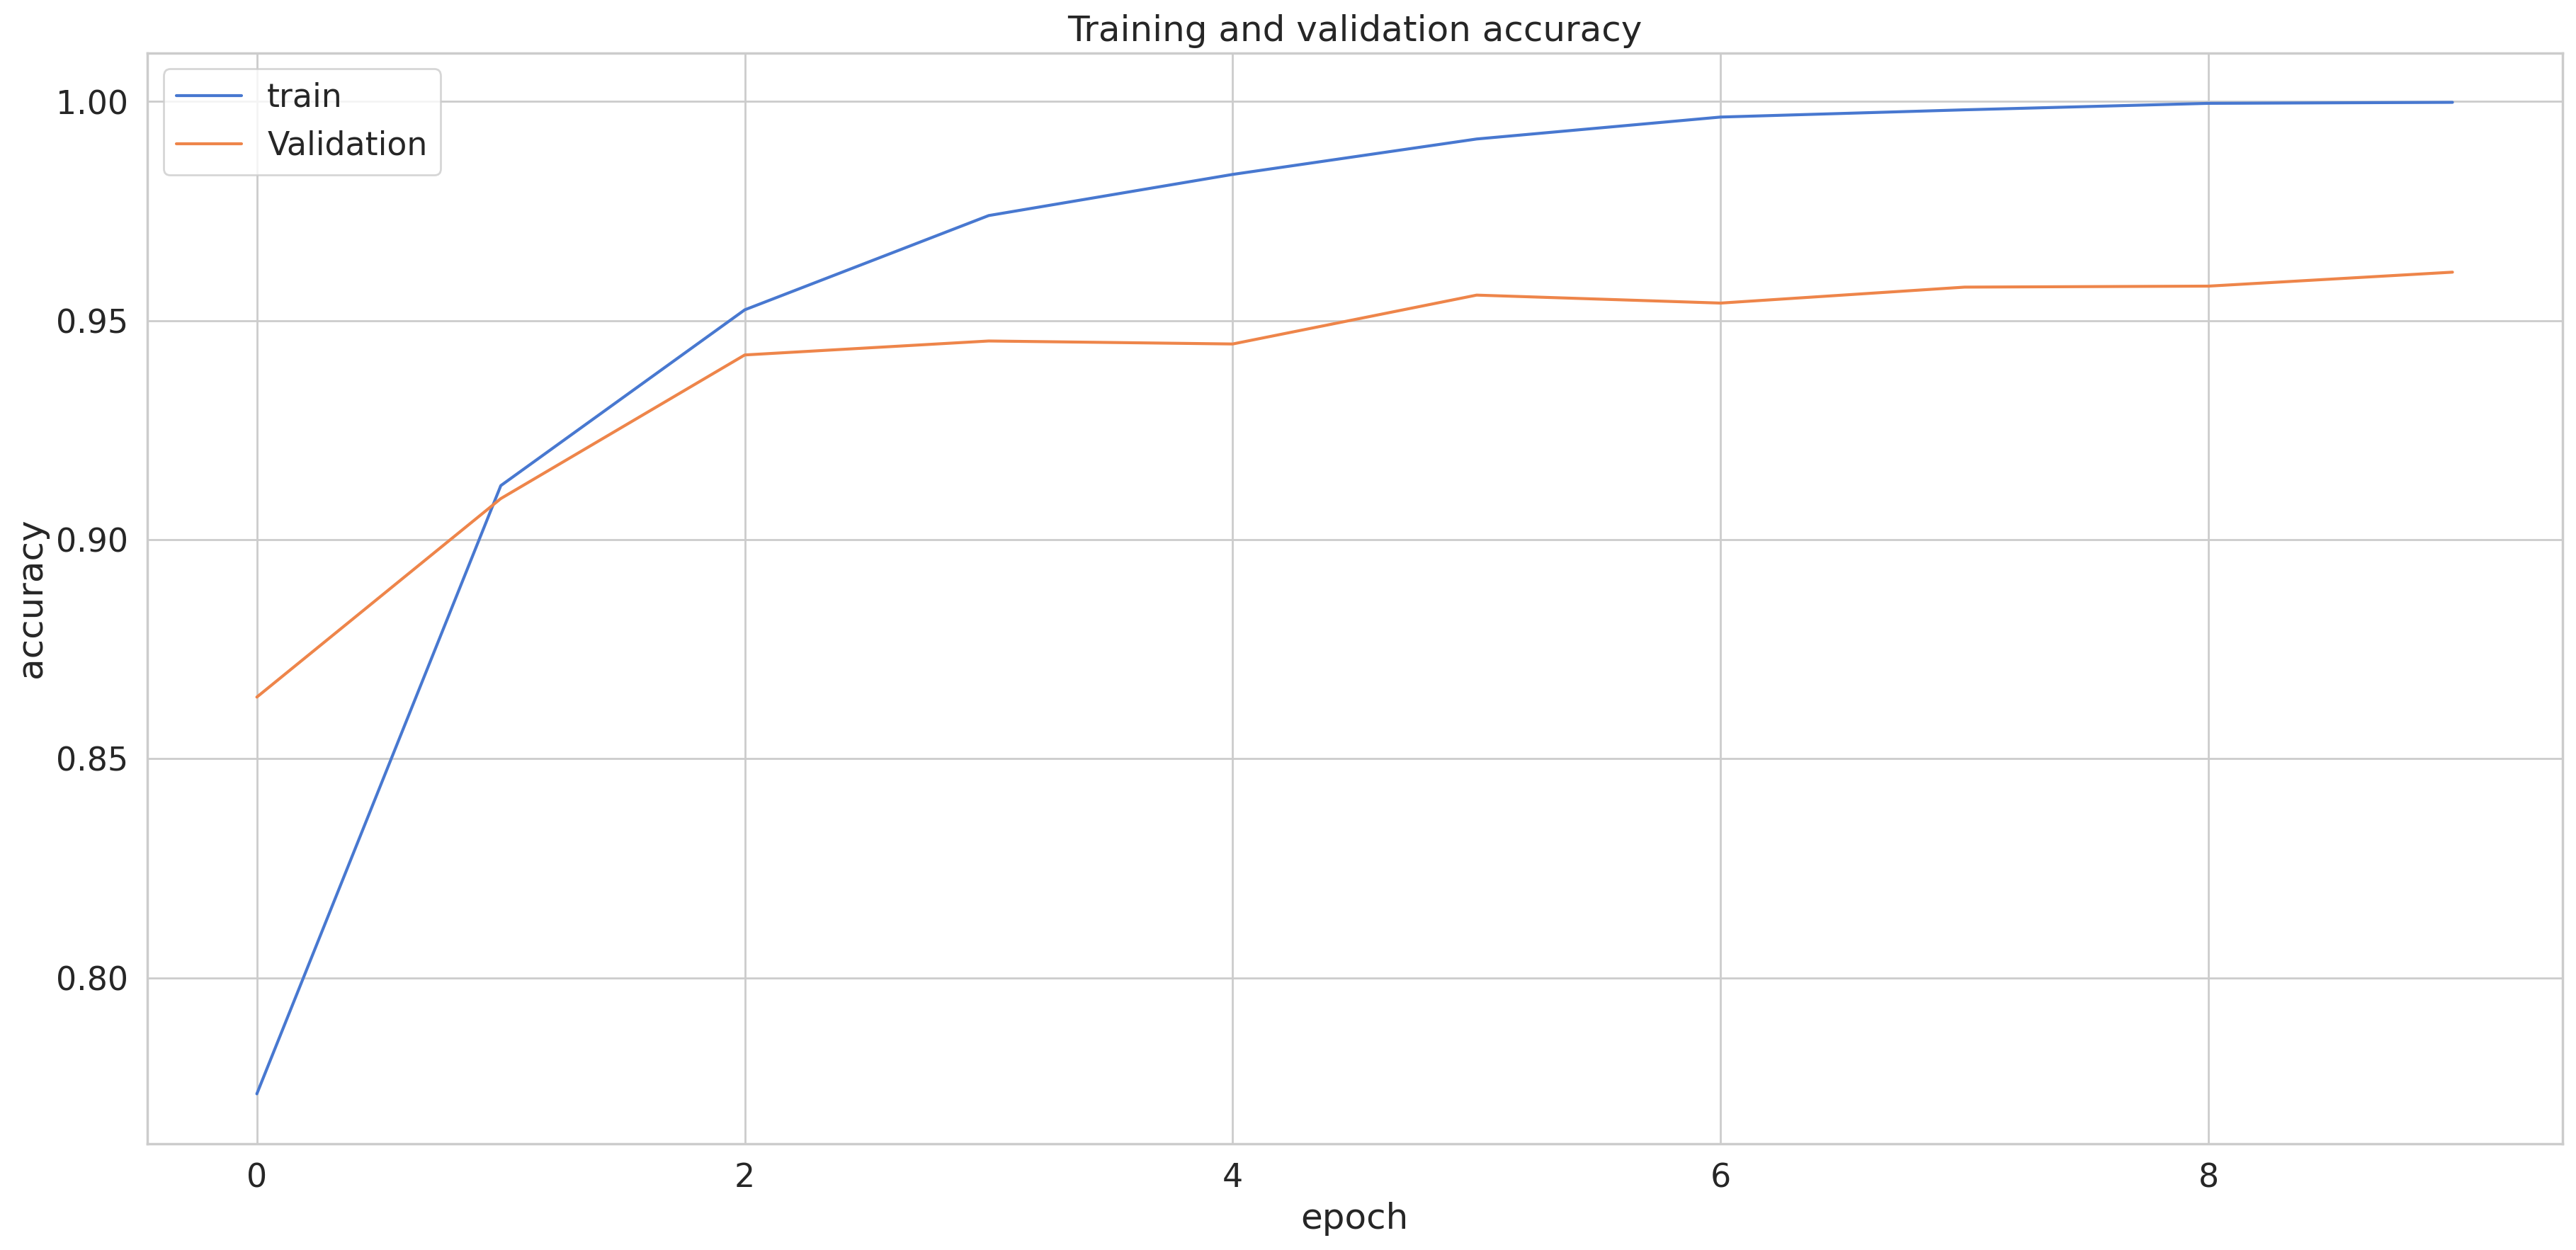

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 2s 9ms/step
f1_score =  0.9583385787303944
0.9588417410307777
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2123
           1       0.98      0.99      0.98      1710
           2       0.87      0.84      0.85       614
           3       0.87      0.83      0.85       502
           4       1.00      1.00      1.00       300
           5       1.00      0.97      0.98       242

    accuracy                           0.96      5491
   macro avg       0.95      0.94      0.94      5491
weighted avg       0.96      0.96      0.96      5491



<Axes: >

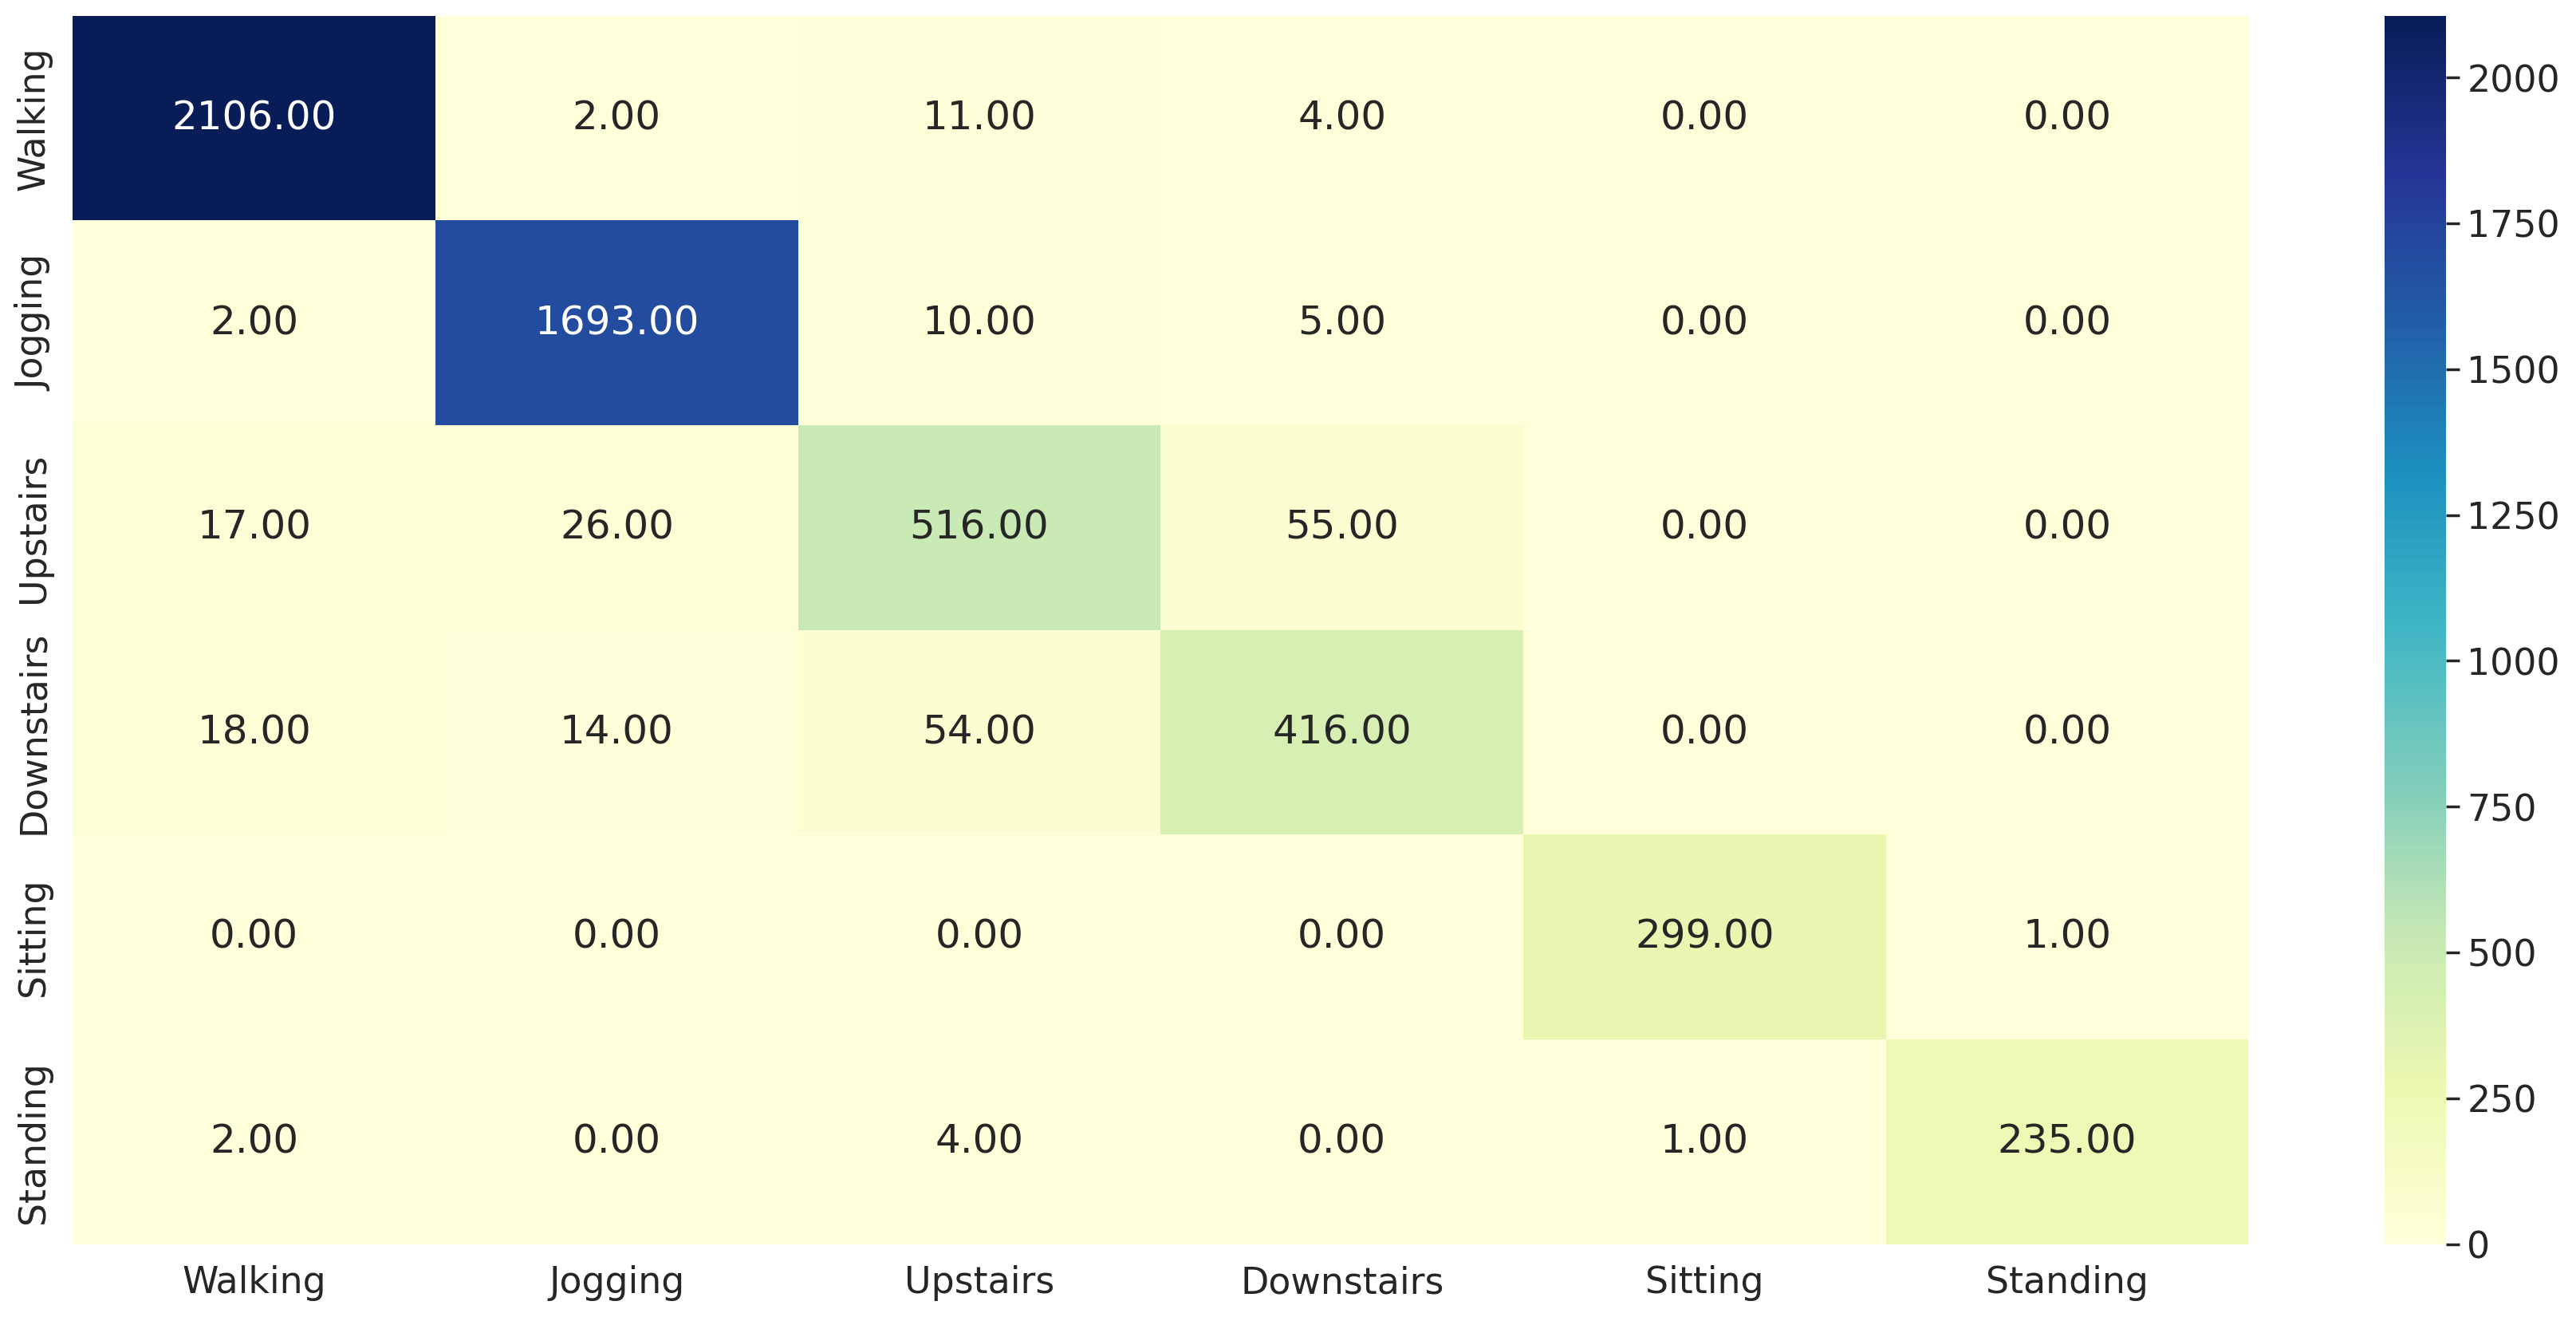

In [58]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN3</h1>

In [59]:
# Model 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_4 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 97, 64)            0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 6208)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               794752    
                                                      

In [60]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 22s 151ms/step - loss: 0.5516 - accuracy: 0.7926 - val_loss: 0.2677 - val_accuracy: 0.8932
Epoch 2/10
138/138 [==============================] - 18s 134ms/step - loss: 0.2140 - accuracy: 0.9208 - val_loss: 0.1685 - val_accuracy: 0.9413
Epoch 3/10
138/138 [==============================] - 21s 152ms/step - loss: 0.1268 - accuracy: 0.9587 - val_loss: 0.1447 - val_accuracy: 0.9492
Epoch 4/10
138/138 [==============================] - 19s 139ms/step - loss: 0.0740 - accuracy: 0.9772 - val_loss: 0.0925 - val_accuracy: 0.9713
Epoch 5/10
138/138 [==============================] - 21s 151ms/step - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0912 - val_accuracy: 0.9706
Epoch 6/10
138/138 [==============================] - 20s 142ms/step - loss: 0.0310 - accuracy: 0.9909 - val_loss: 0.1090 - val_accuracy: 0.9631
Epoch 7/10
138/138 [==============================] - 20s 145ms/step - loss: 0.0207 - accuracy: 0.9944 - val_loss: 0.0760 - val_ac

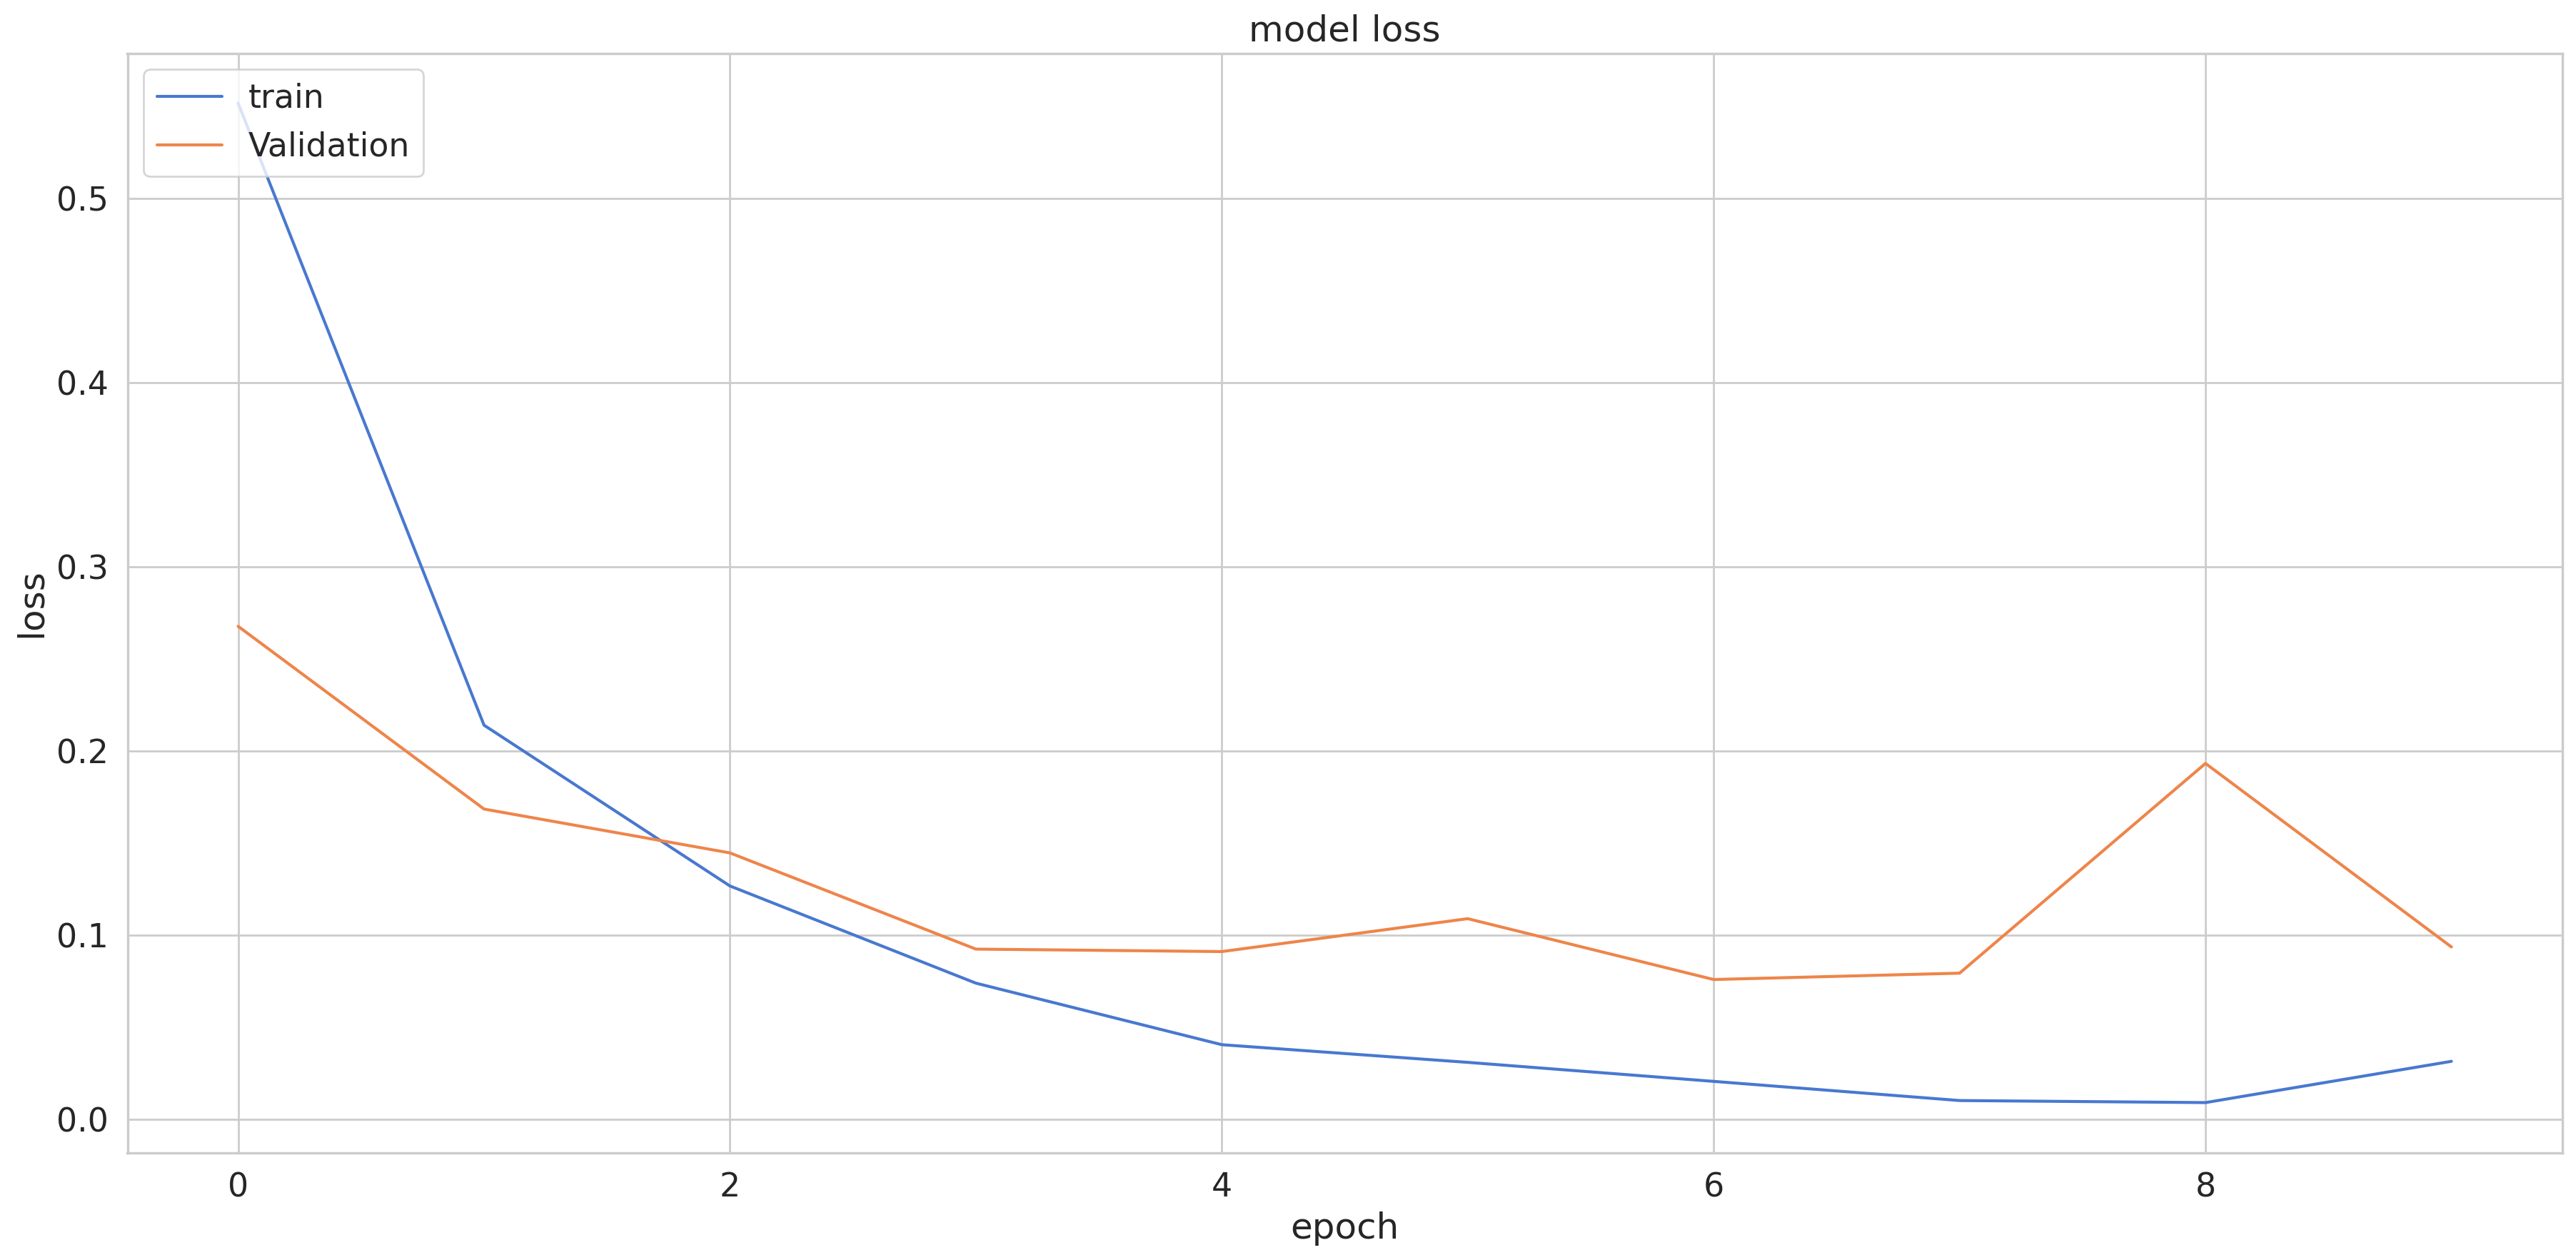

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

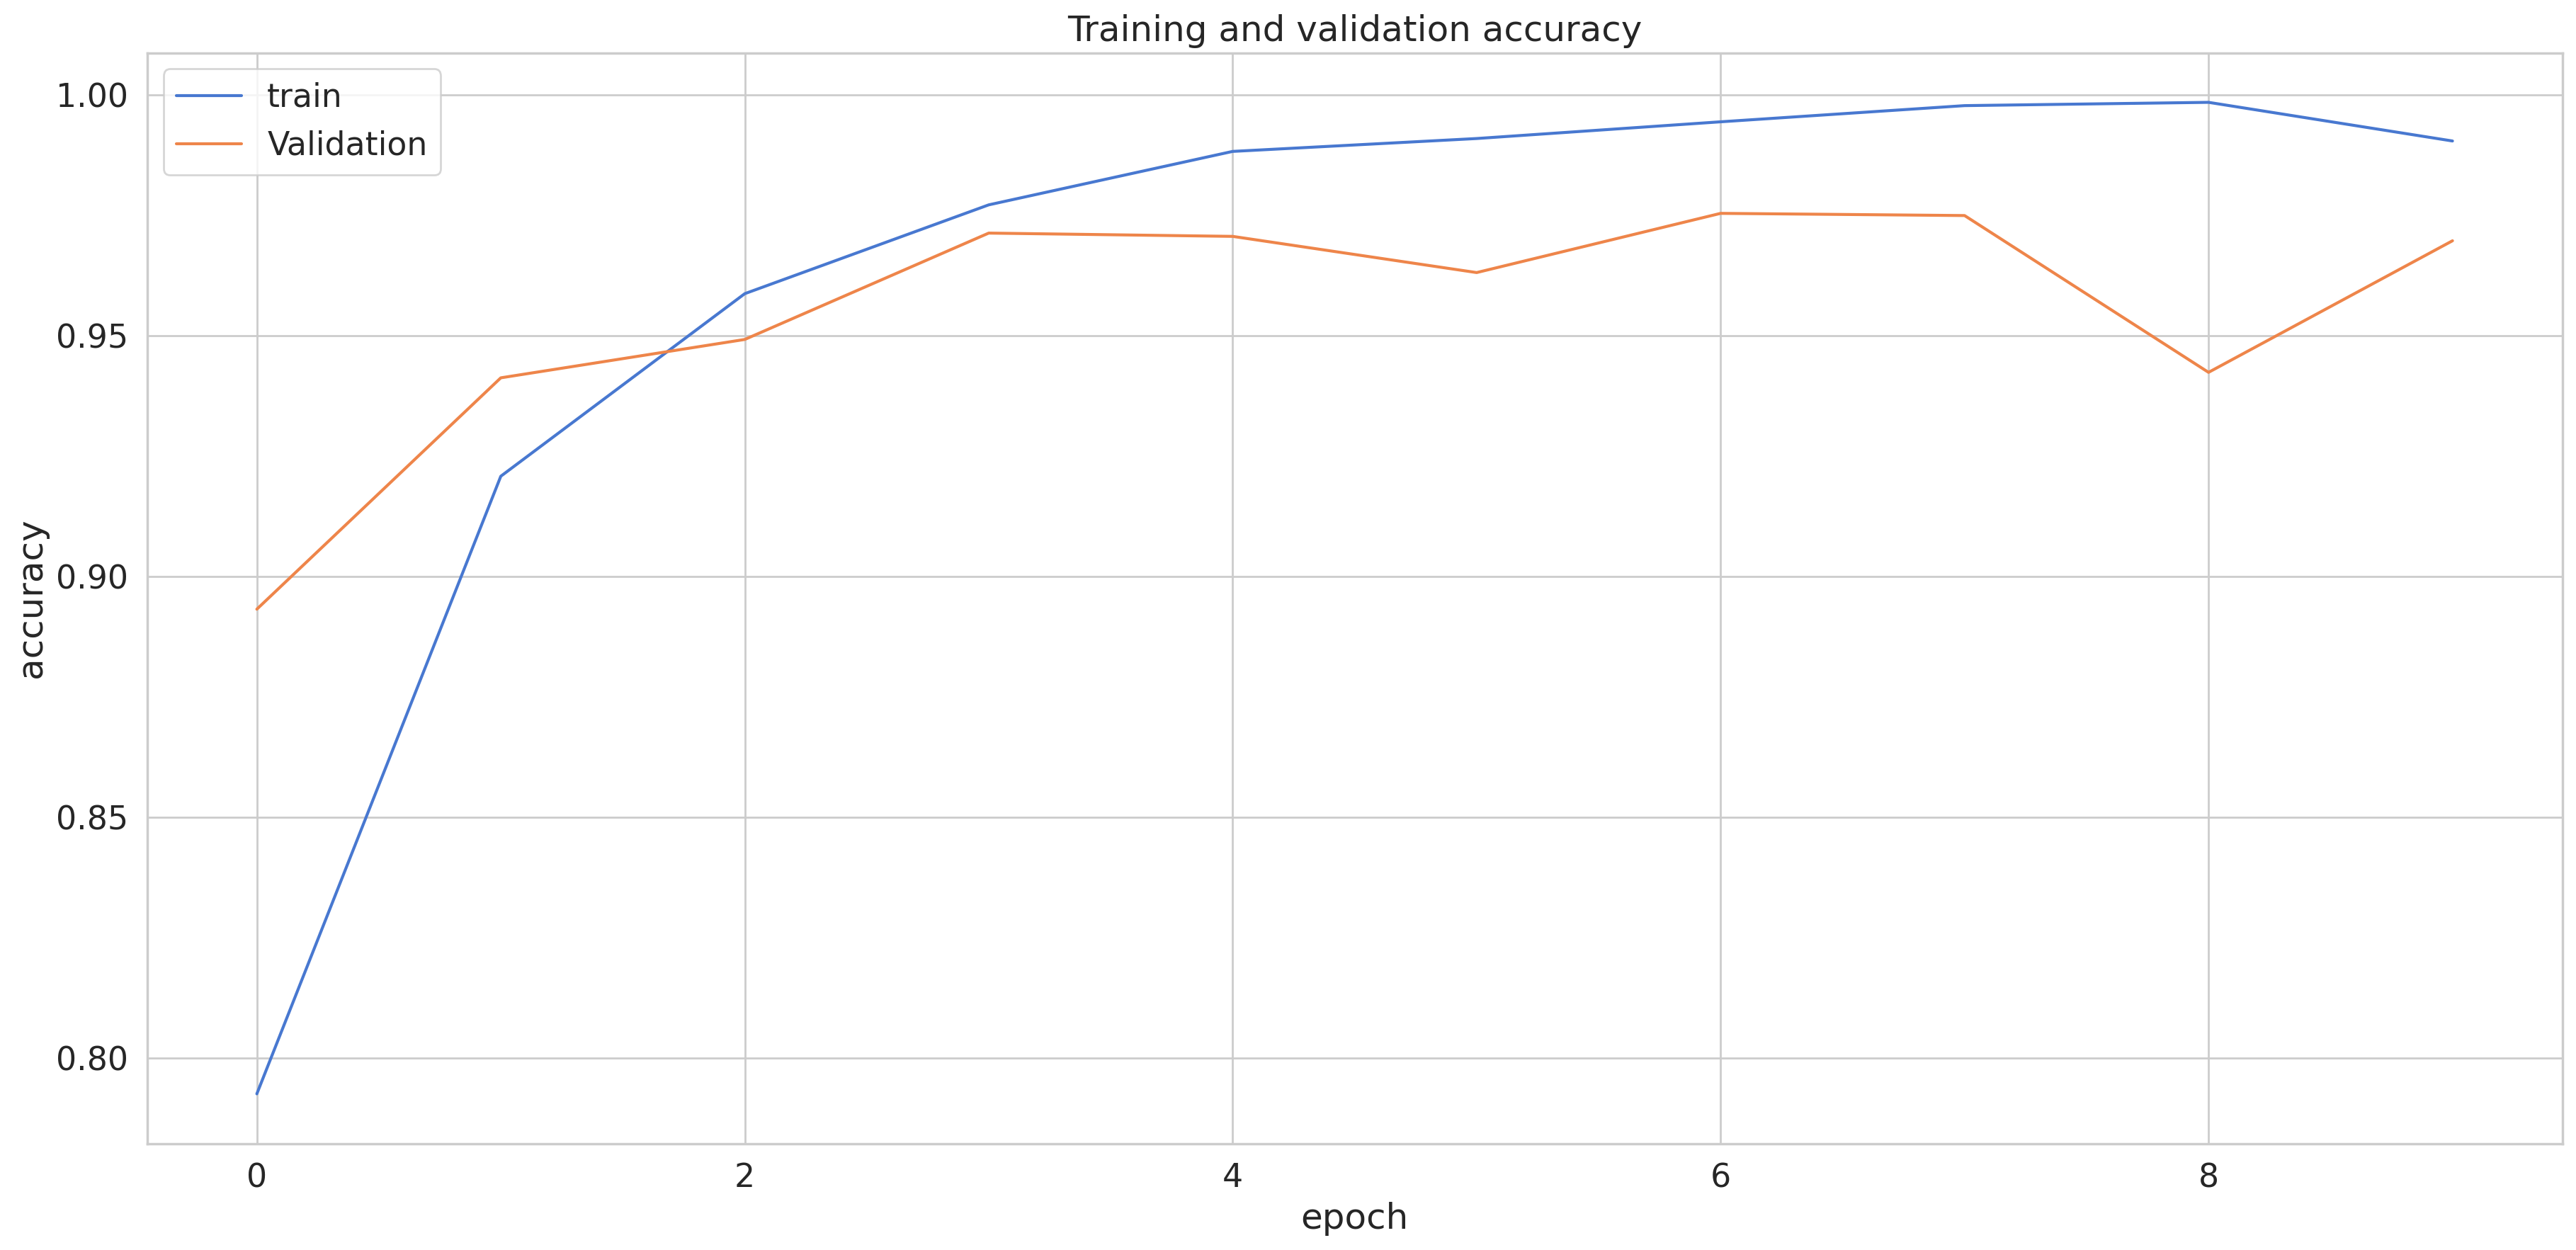

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 2s 12ms/step
f1_score =  0.9710616512934643
0.9714077581496995
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.97      0.82      0.89       614
           3       0.85      0.97      0.91       502
           4       1.00      1.00      1.00       300
           5       1.00      0.98      0.99       242

    accuracy                           0.97      5491
   macro avg       0.97      0.96      0.96      5491
weighted avg       0.97      0.97      0.97      5491



<Axes: >

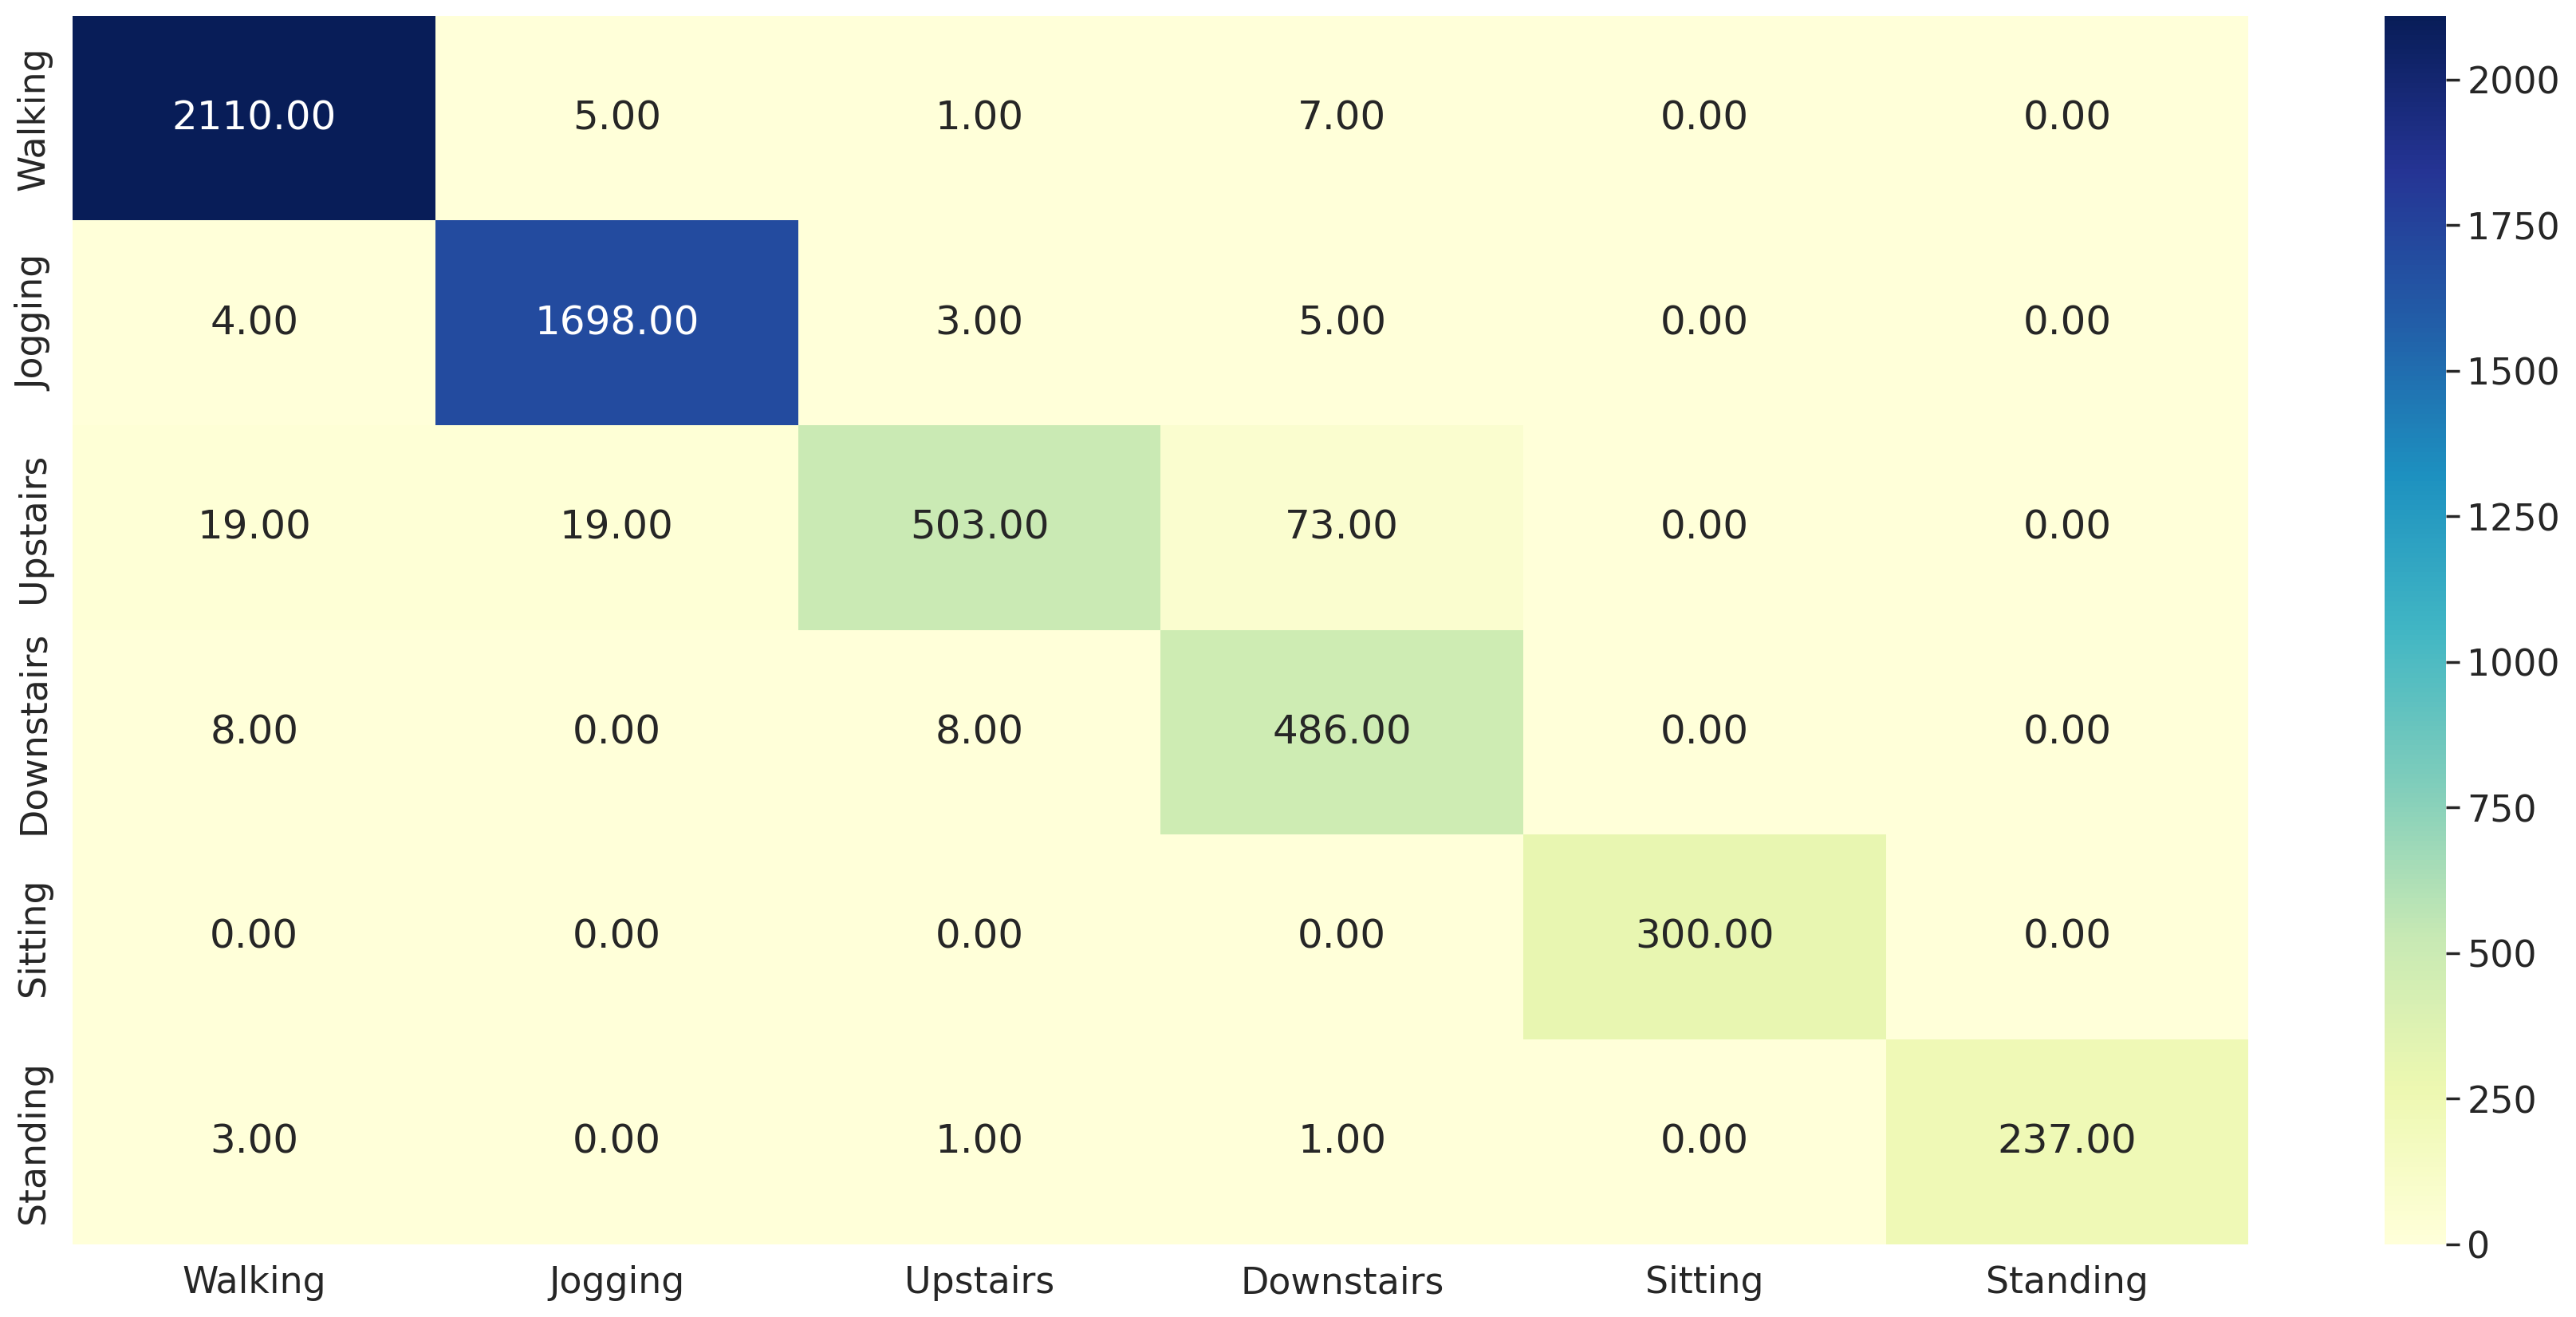

In [63]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 4</h1>

In [64]:
# Model 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_7 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_8 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 conv1d_9 (Conv1D)           (None, 192, 64)           12352     
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               1572992   
                                                                 
 dense_7 (Dense)             (None, 6)                

In [65]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 30s 211ms/step - loss: 0.5616 - accuracy: 0.7862 - val_loss: 0.3021 - val_accuracy: 0.8823
Epoch 2/10
138/138 [==============================] - 29s 213ms/step - loss: 0.2076 - accuracy: 0.9246 - val_loss: 0.1444 - val_accuracy: 0.9536
Epoch 3/10
138/138 [==============================] - 29s 212ms/step - loss: 0.1073 - accuracy: 0.9647 - val_loss: 0.1005 - val_accuracy: 0.9684
Epoch 4/10
138/138 [==============================] - 29s 211ms/step - loss: 0.0686 - accuracy: 0.9773 - val_loss: 0.0891 - val_accuracy: 0.9722
Epoch 5/10
138/138 [==============================] - 29s 211ms/step - loss: 0.0440 - accuracy: 0.9870 - val_loss: 0.0995 - val_accuracy: 0.9709
Epoch 6/10
138/138 [==============================] - 29s 207ms/step - loss: 0.0343 - accuracy: 0.9890 - val_loss: 0.1065 - val_accuracy: 0.9645
Epoch 7/10
138/138 [==============================] - 29s 209ms/step - loss: 0.0185 - accuracy: 0.9947 - val_loss: 0.1925 - val_ac

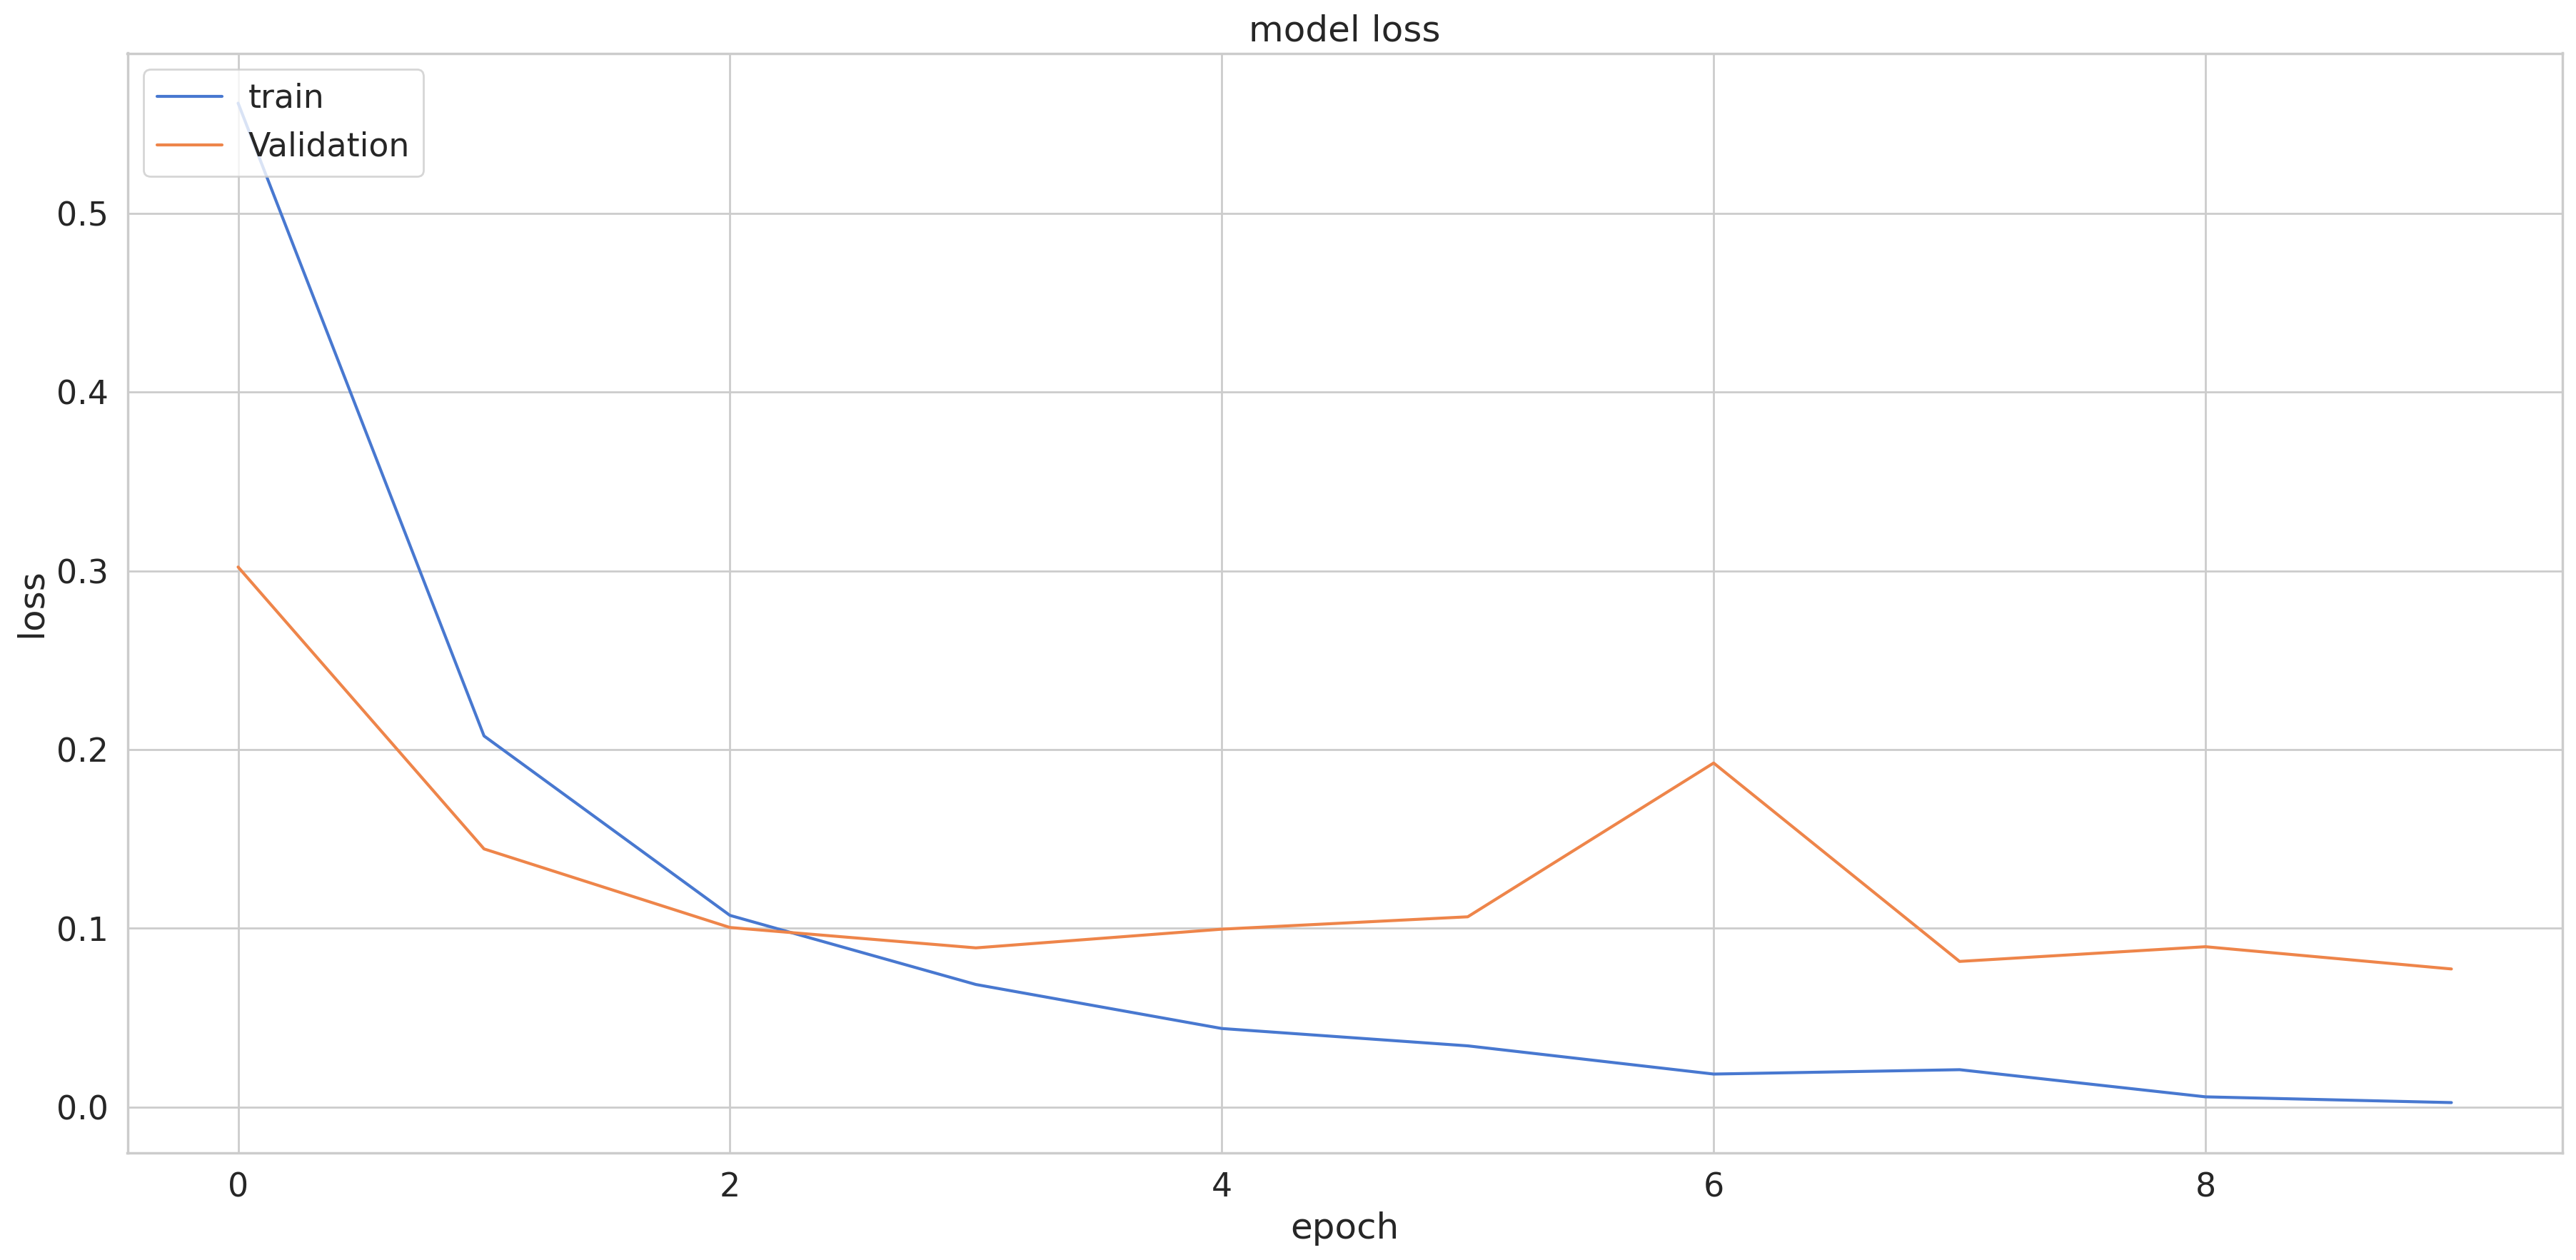

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

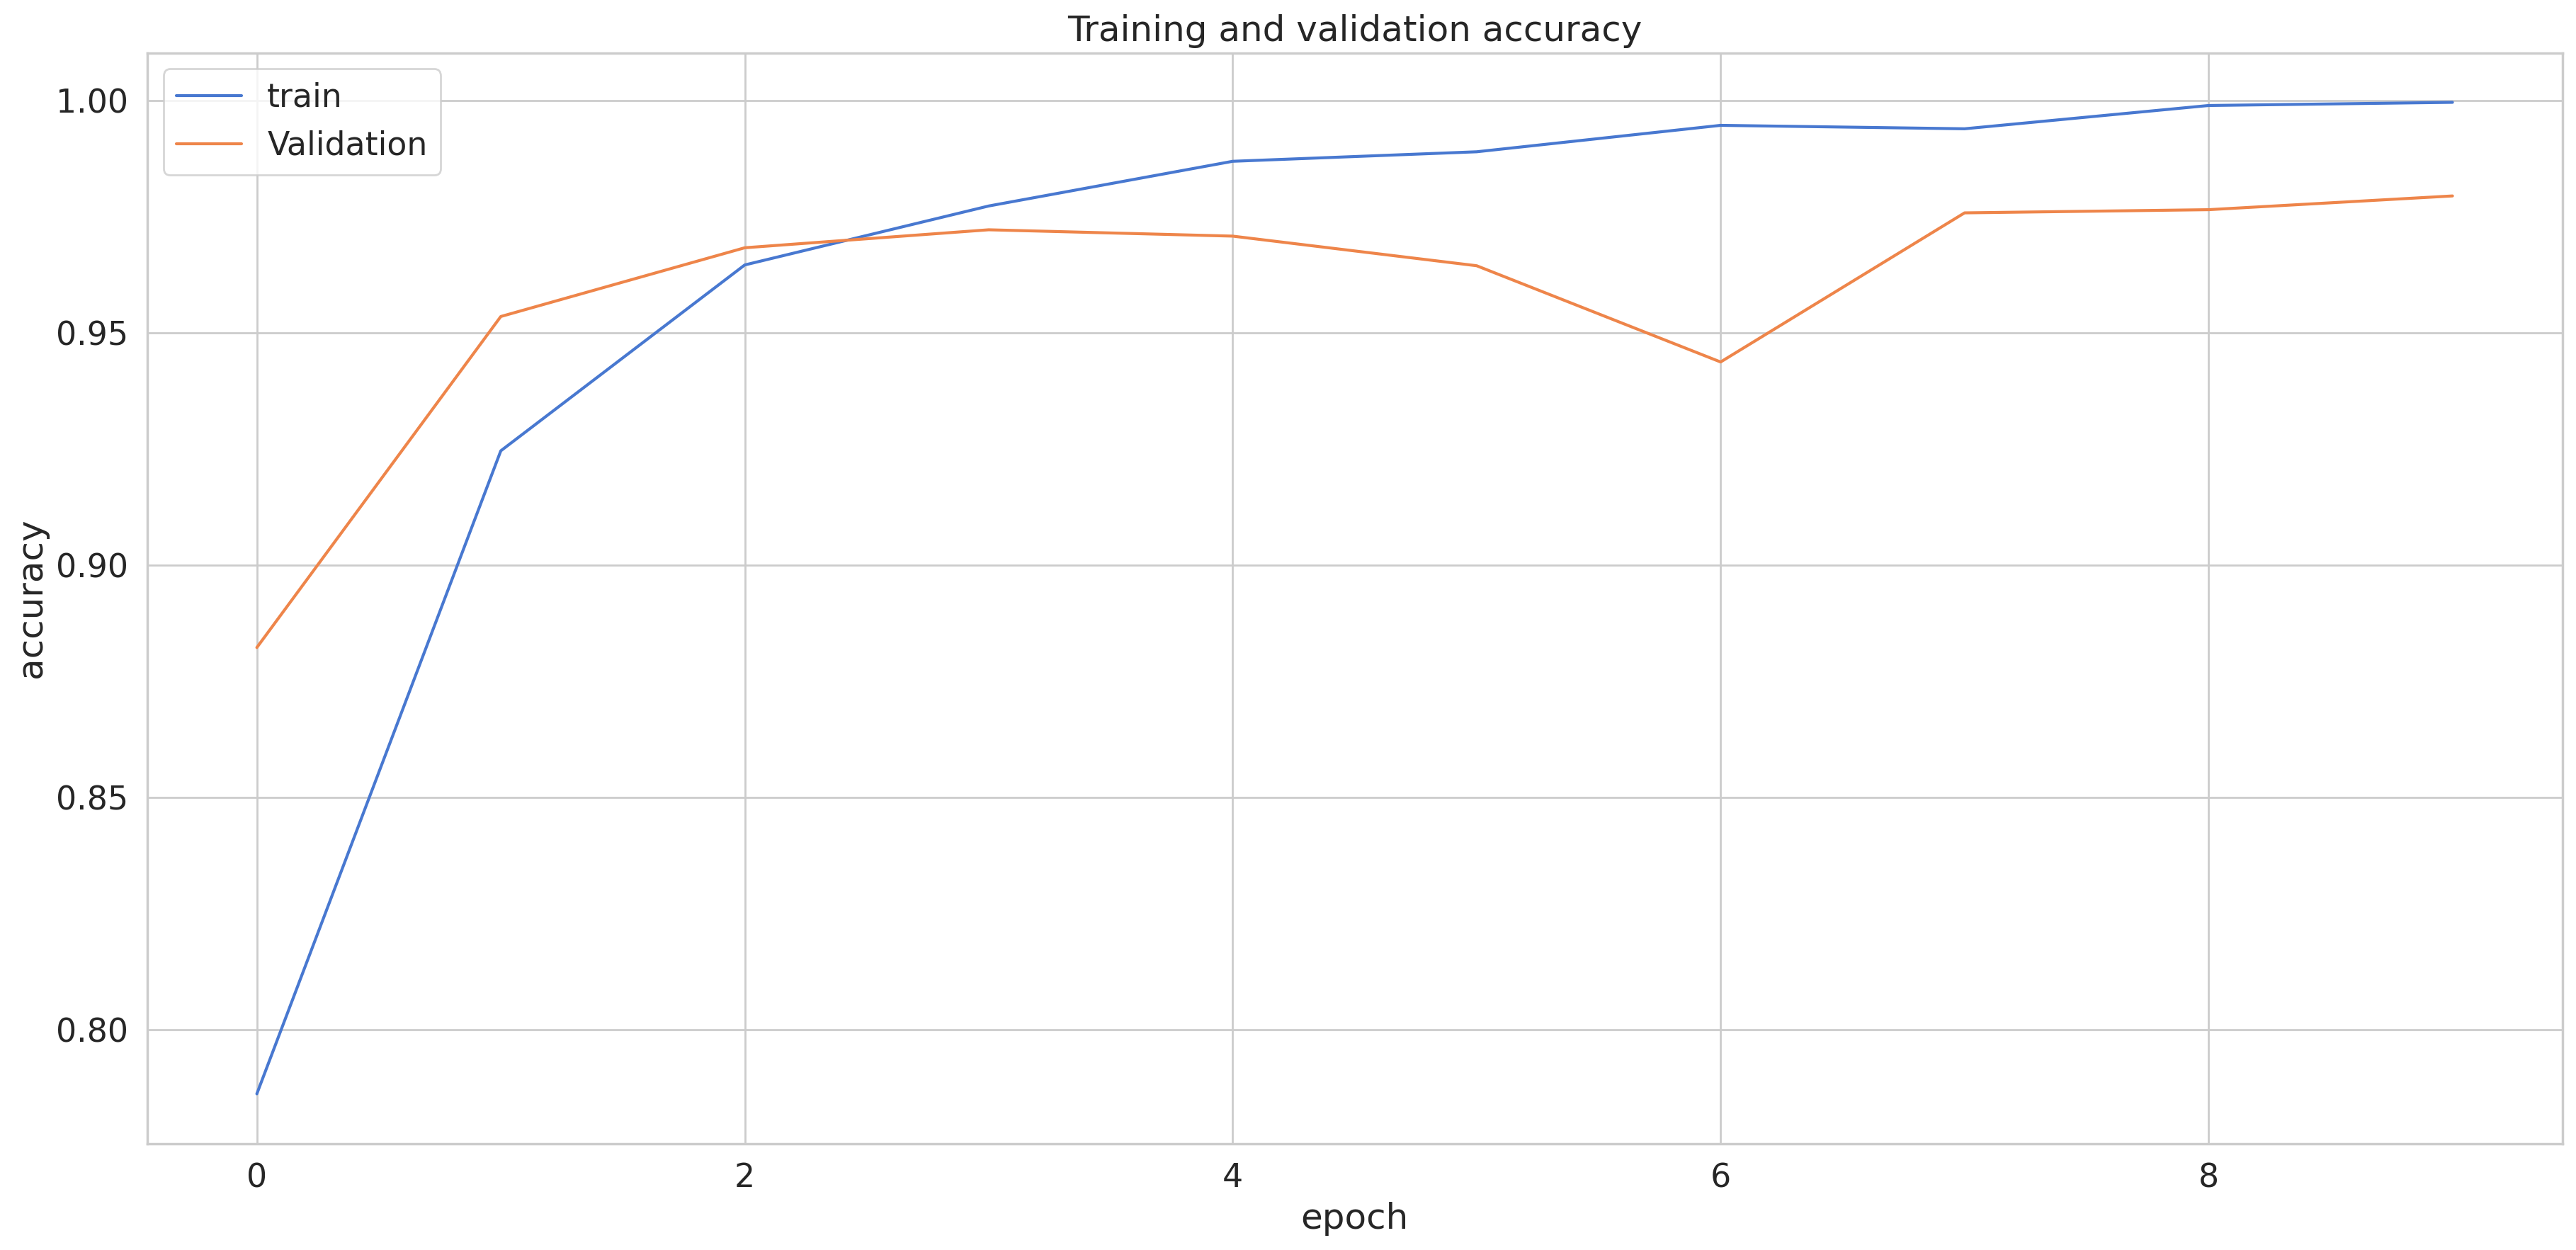

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 18ms/step
f1_score =  0.9786508414791081
0.9786924057548716
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.93      0.92      0.92       614
           3       0.92      0.92      0.92       502
           4       0.99      1.00      1.00       300
           5       0.99      0.98      0.98       242

    accuracy                           0.98      5491
   macro avg       0.97      0.97      0.97      5491
weighted avg       0.98      0.98      0.98      5491



<Axes: >

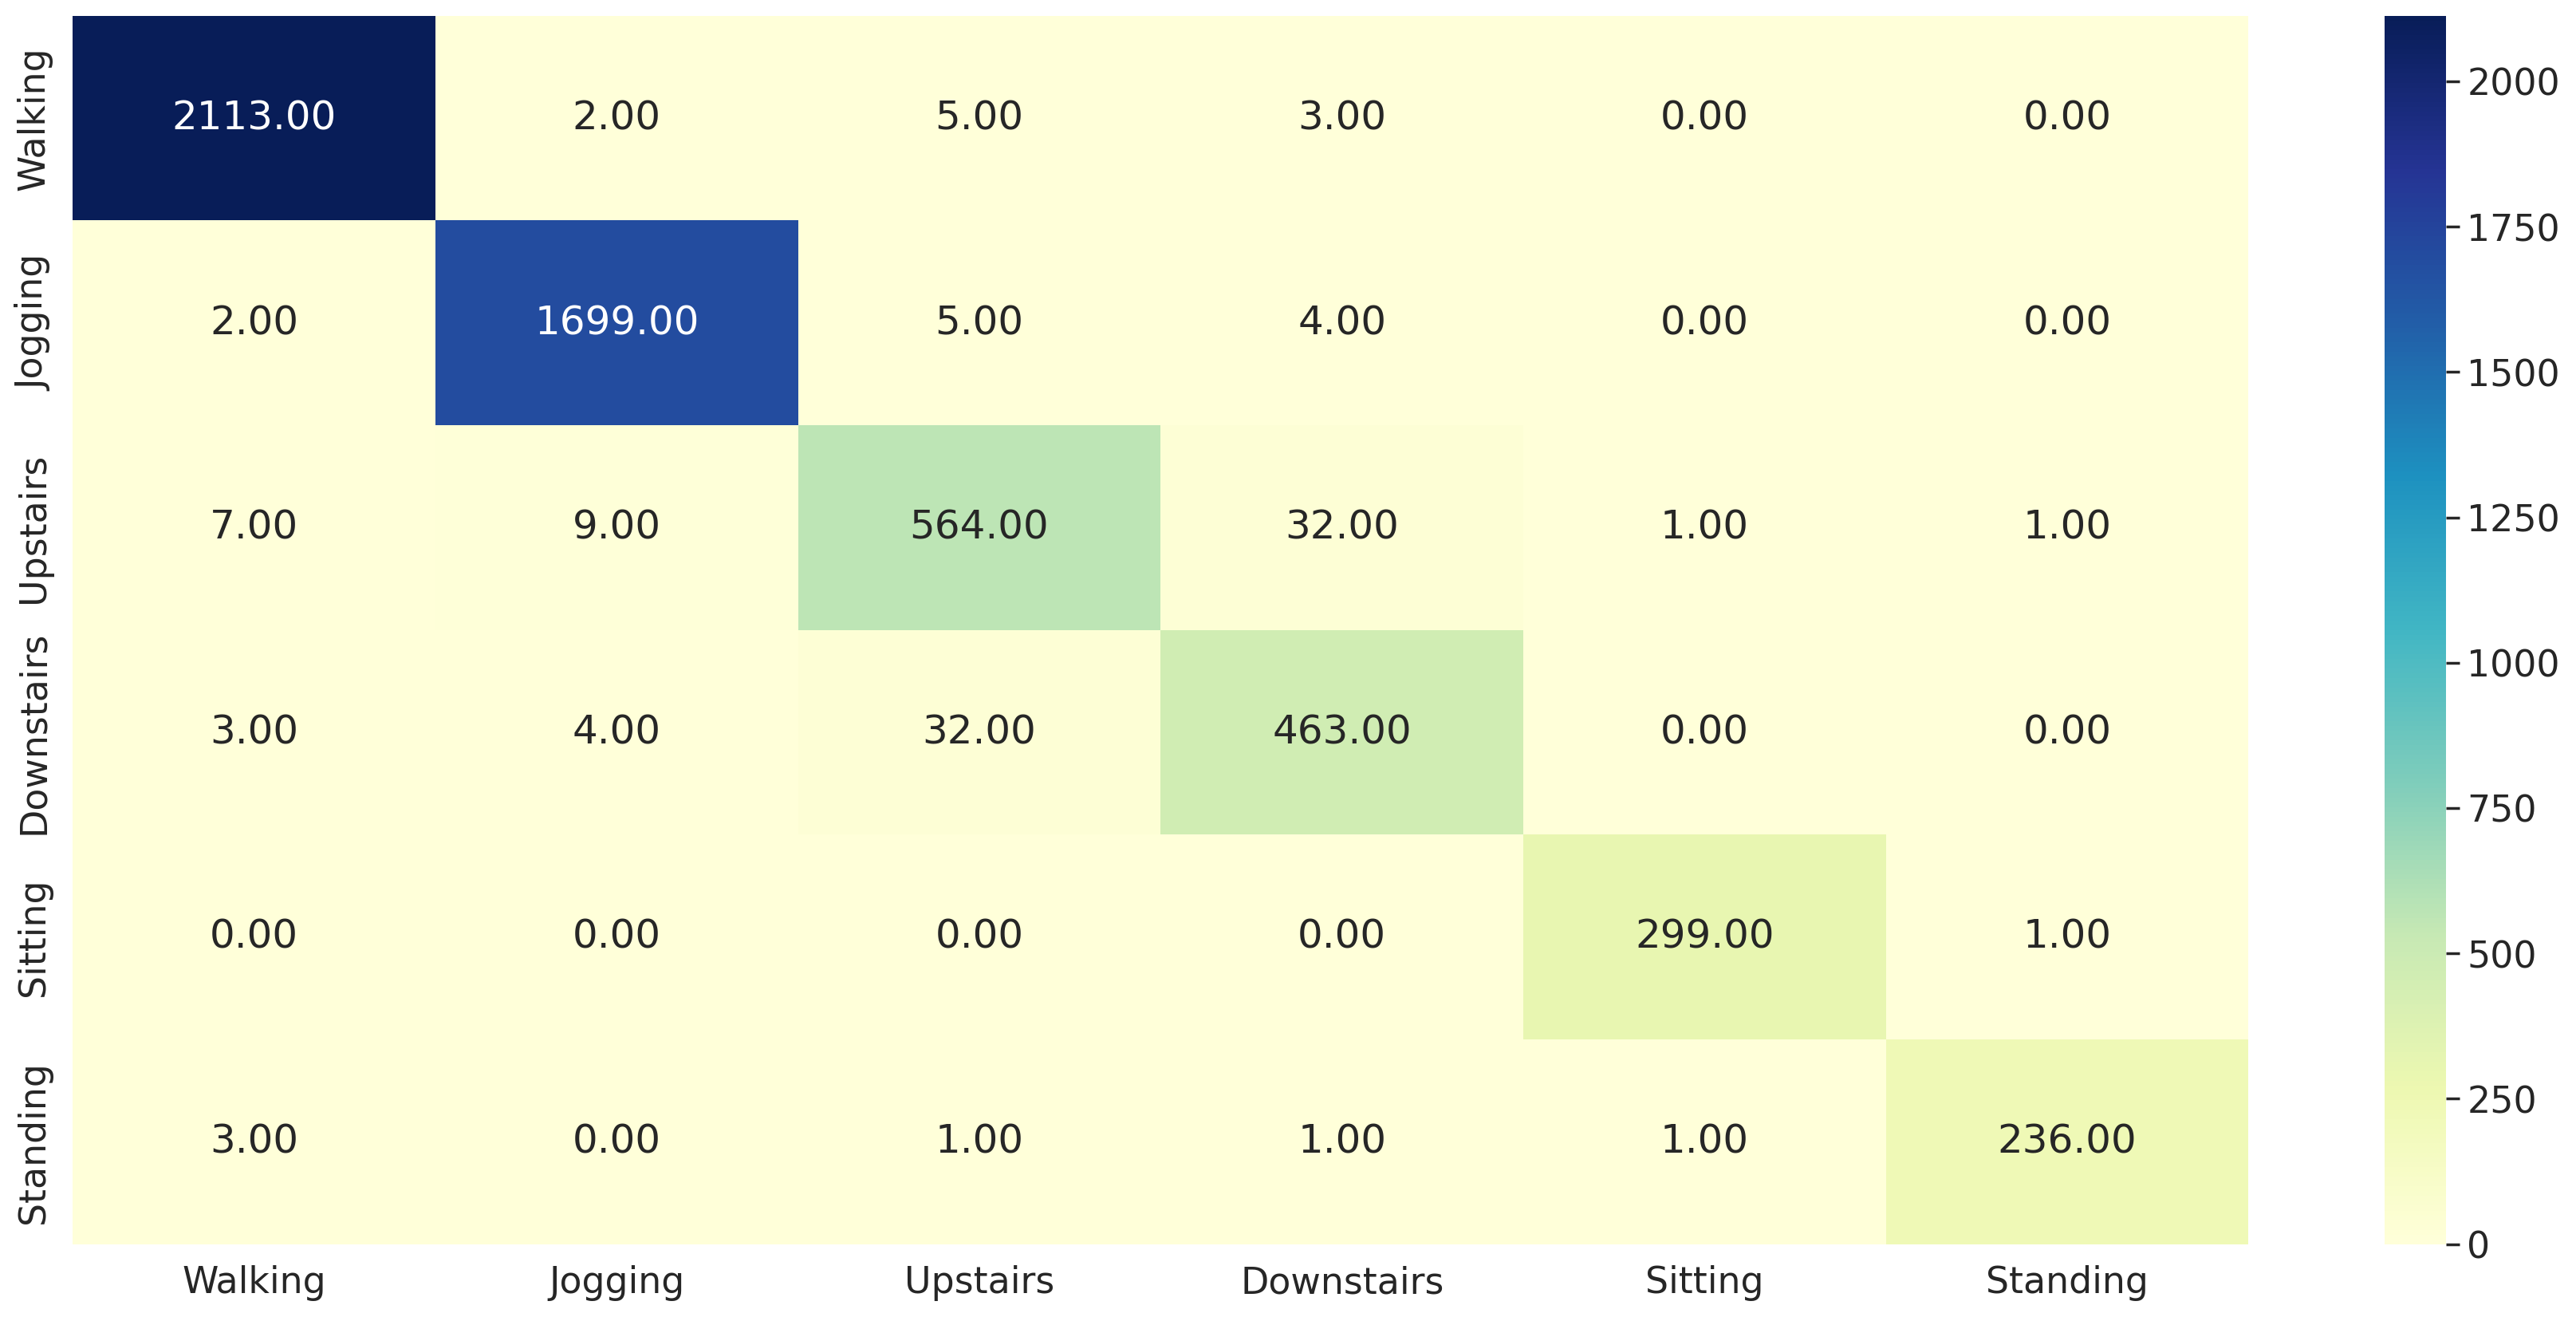

In [68]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 5</h5>

In [69]:
# Model 5
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

#model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 198, 64)           640       
                                                                 
 conv1d_11 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 conv1d_12 (Conv1D)          (None, 194, 64)           12352     
                                                                 
 conv1d_13 (Conv1D)          (None, 192, 64)           12352     
                                                                 
 conv1d_14 (Conv1D)          (None, 190, 64)           12352     
                                                                 
 flatten_4 (Flatten)         (None, 12160)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [70]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 35s 241ms/step - loss: 0.5672 - accuracy: 0.7838 - val_loss: 0.3228 - val_accuracy: 0.8878
Epoch 2/10
138/138 [==============================] - 35s 256ms/step - loss: 0.1924 - accuracy: 0.9320 - val_loss: 0.1701 - val_accuracy: 0.9419
Epoch 3/10
138/138 [==============================] - 34s 245ms/step - loss: 0.1126 - accuracy: 0.9619 - val_loss: 0.0823 - val_accuracy: 0.9756
Epoch 4/10
138/138 [==============================] - 35s 256ms/step - loss: 0.0643 - accuracy: 0.9795 - val_loss: 0.0663 - val_accuracy: 0.9800
Epoch 5/10
138/138 [==============================] - 34s 246ms/step - loss: 0.0406 - accuracy: 0.9866 - val_loss: 0.0877 - val_accuracy: 0.9736
Epoch 6/10
138/138 [==============================] - 36s 261ms/step - loss: 0.0416 - accuracy: 0.9849 - val_loss: 0.1132 - val_accuracy: 0.9679
Epoch 7/10
138/138 [==============================] - 34s 247ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0640 - val_ac

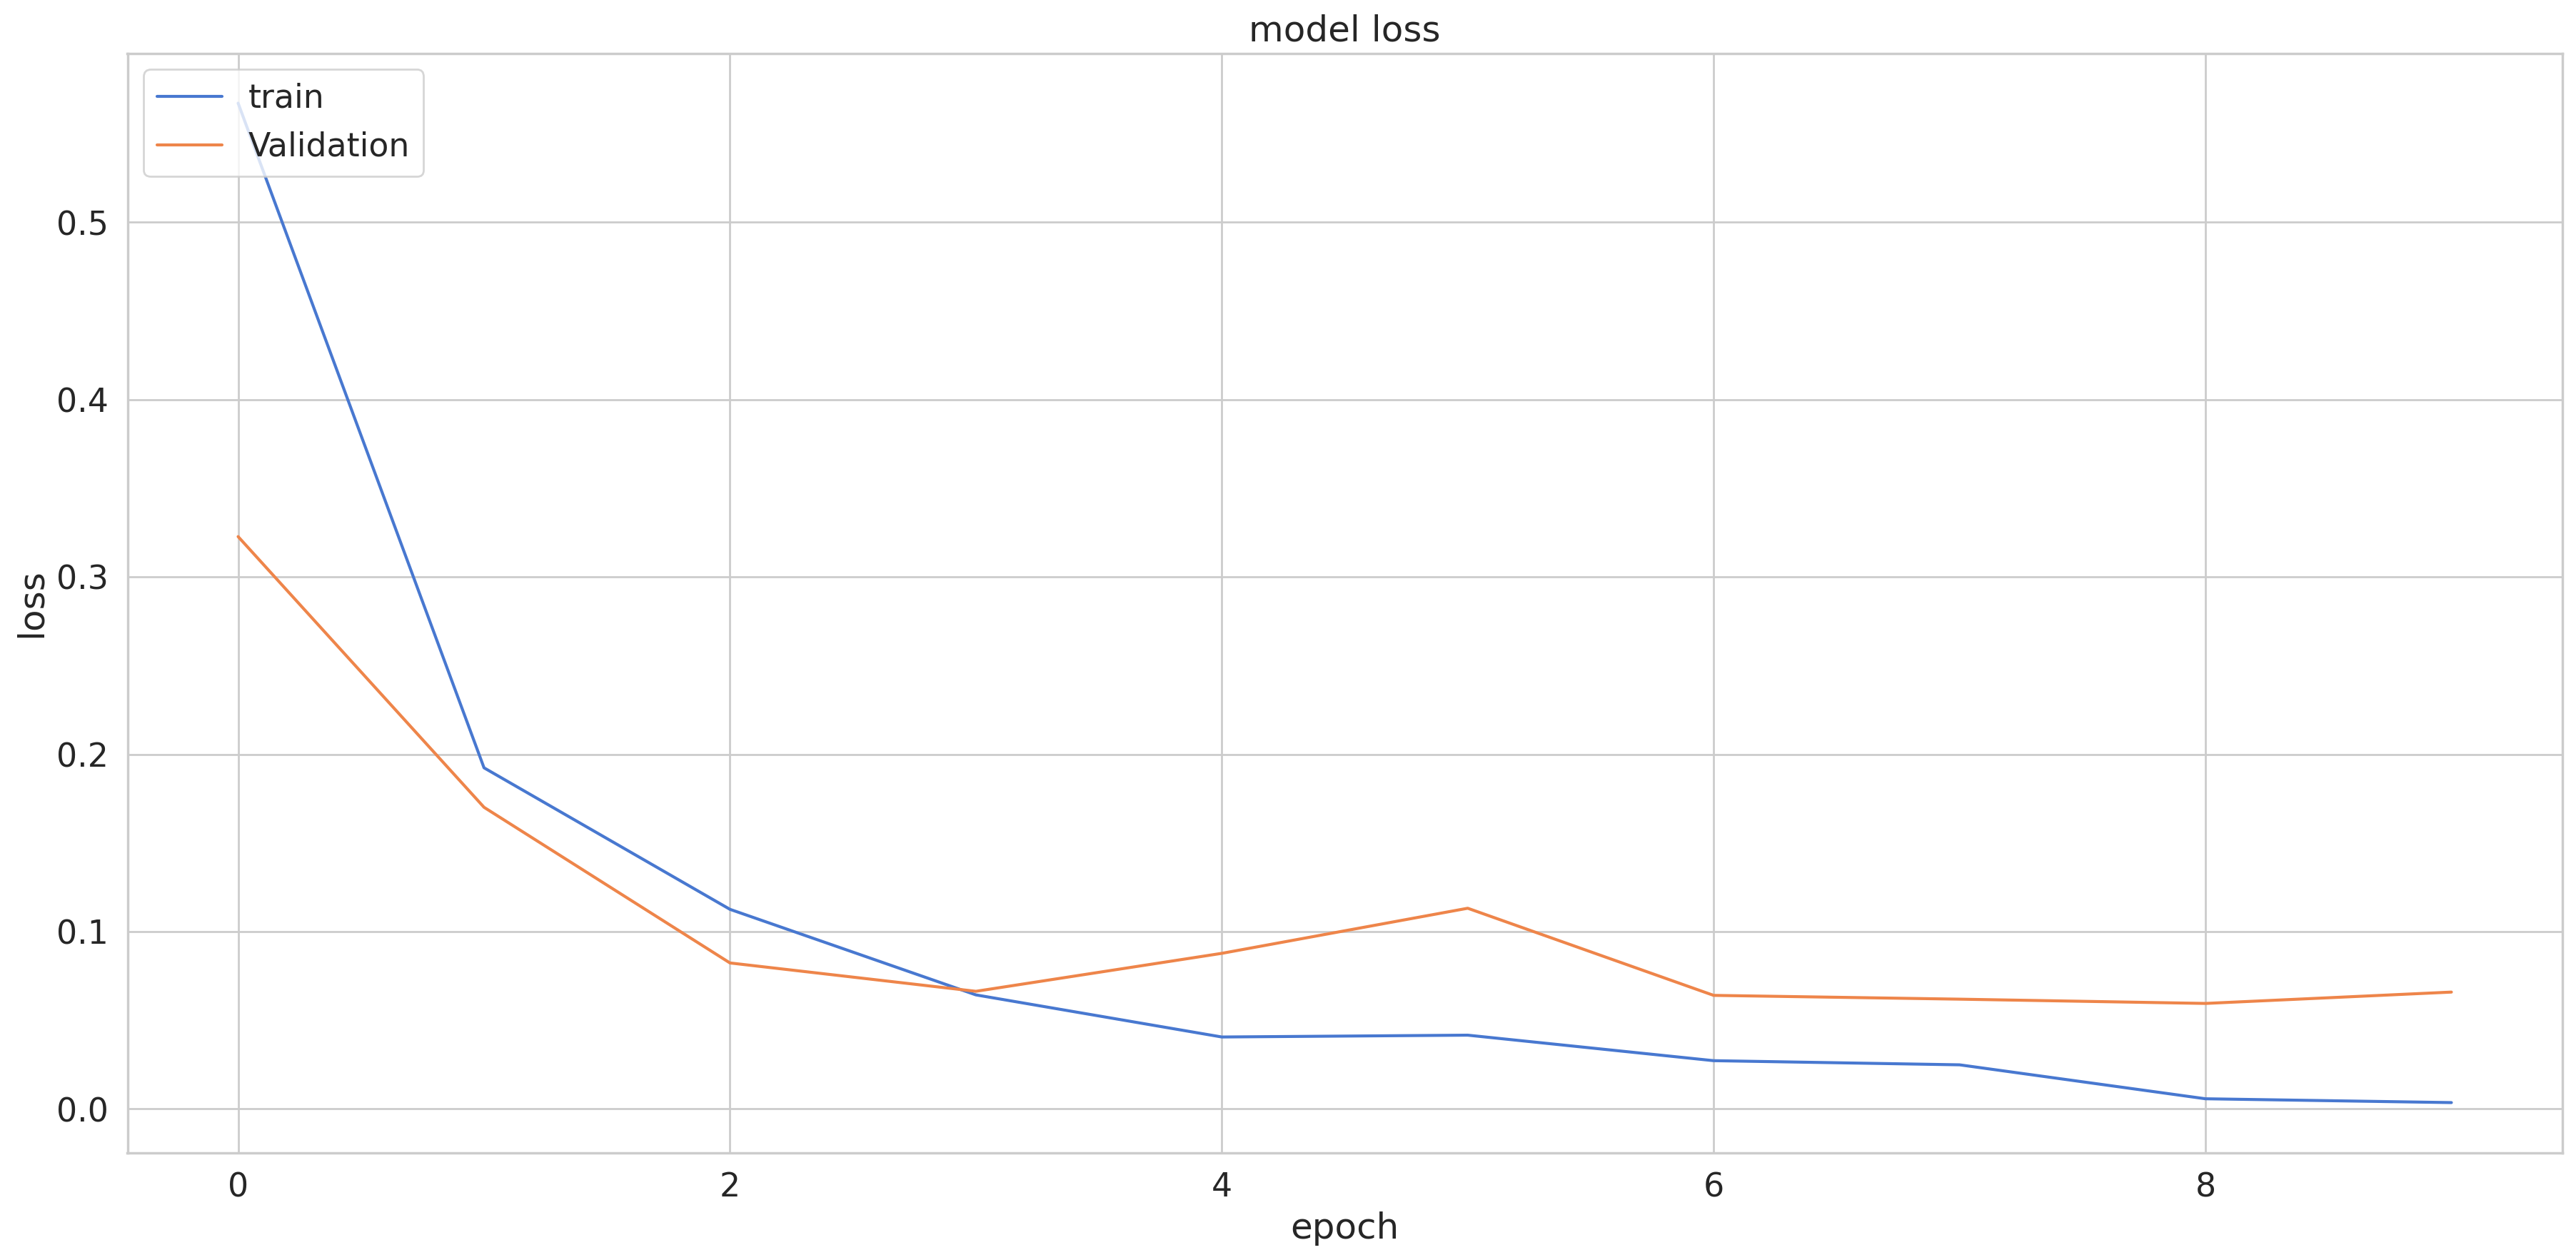

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

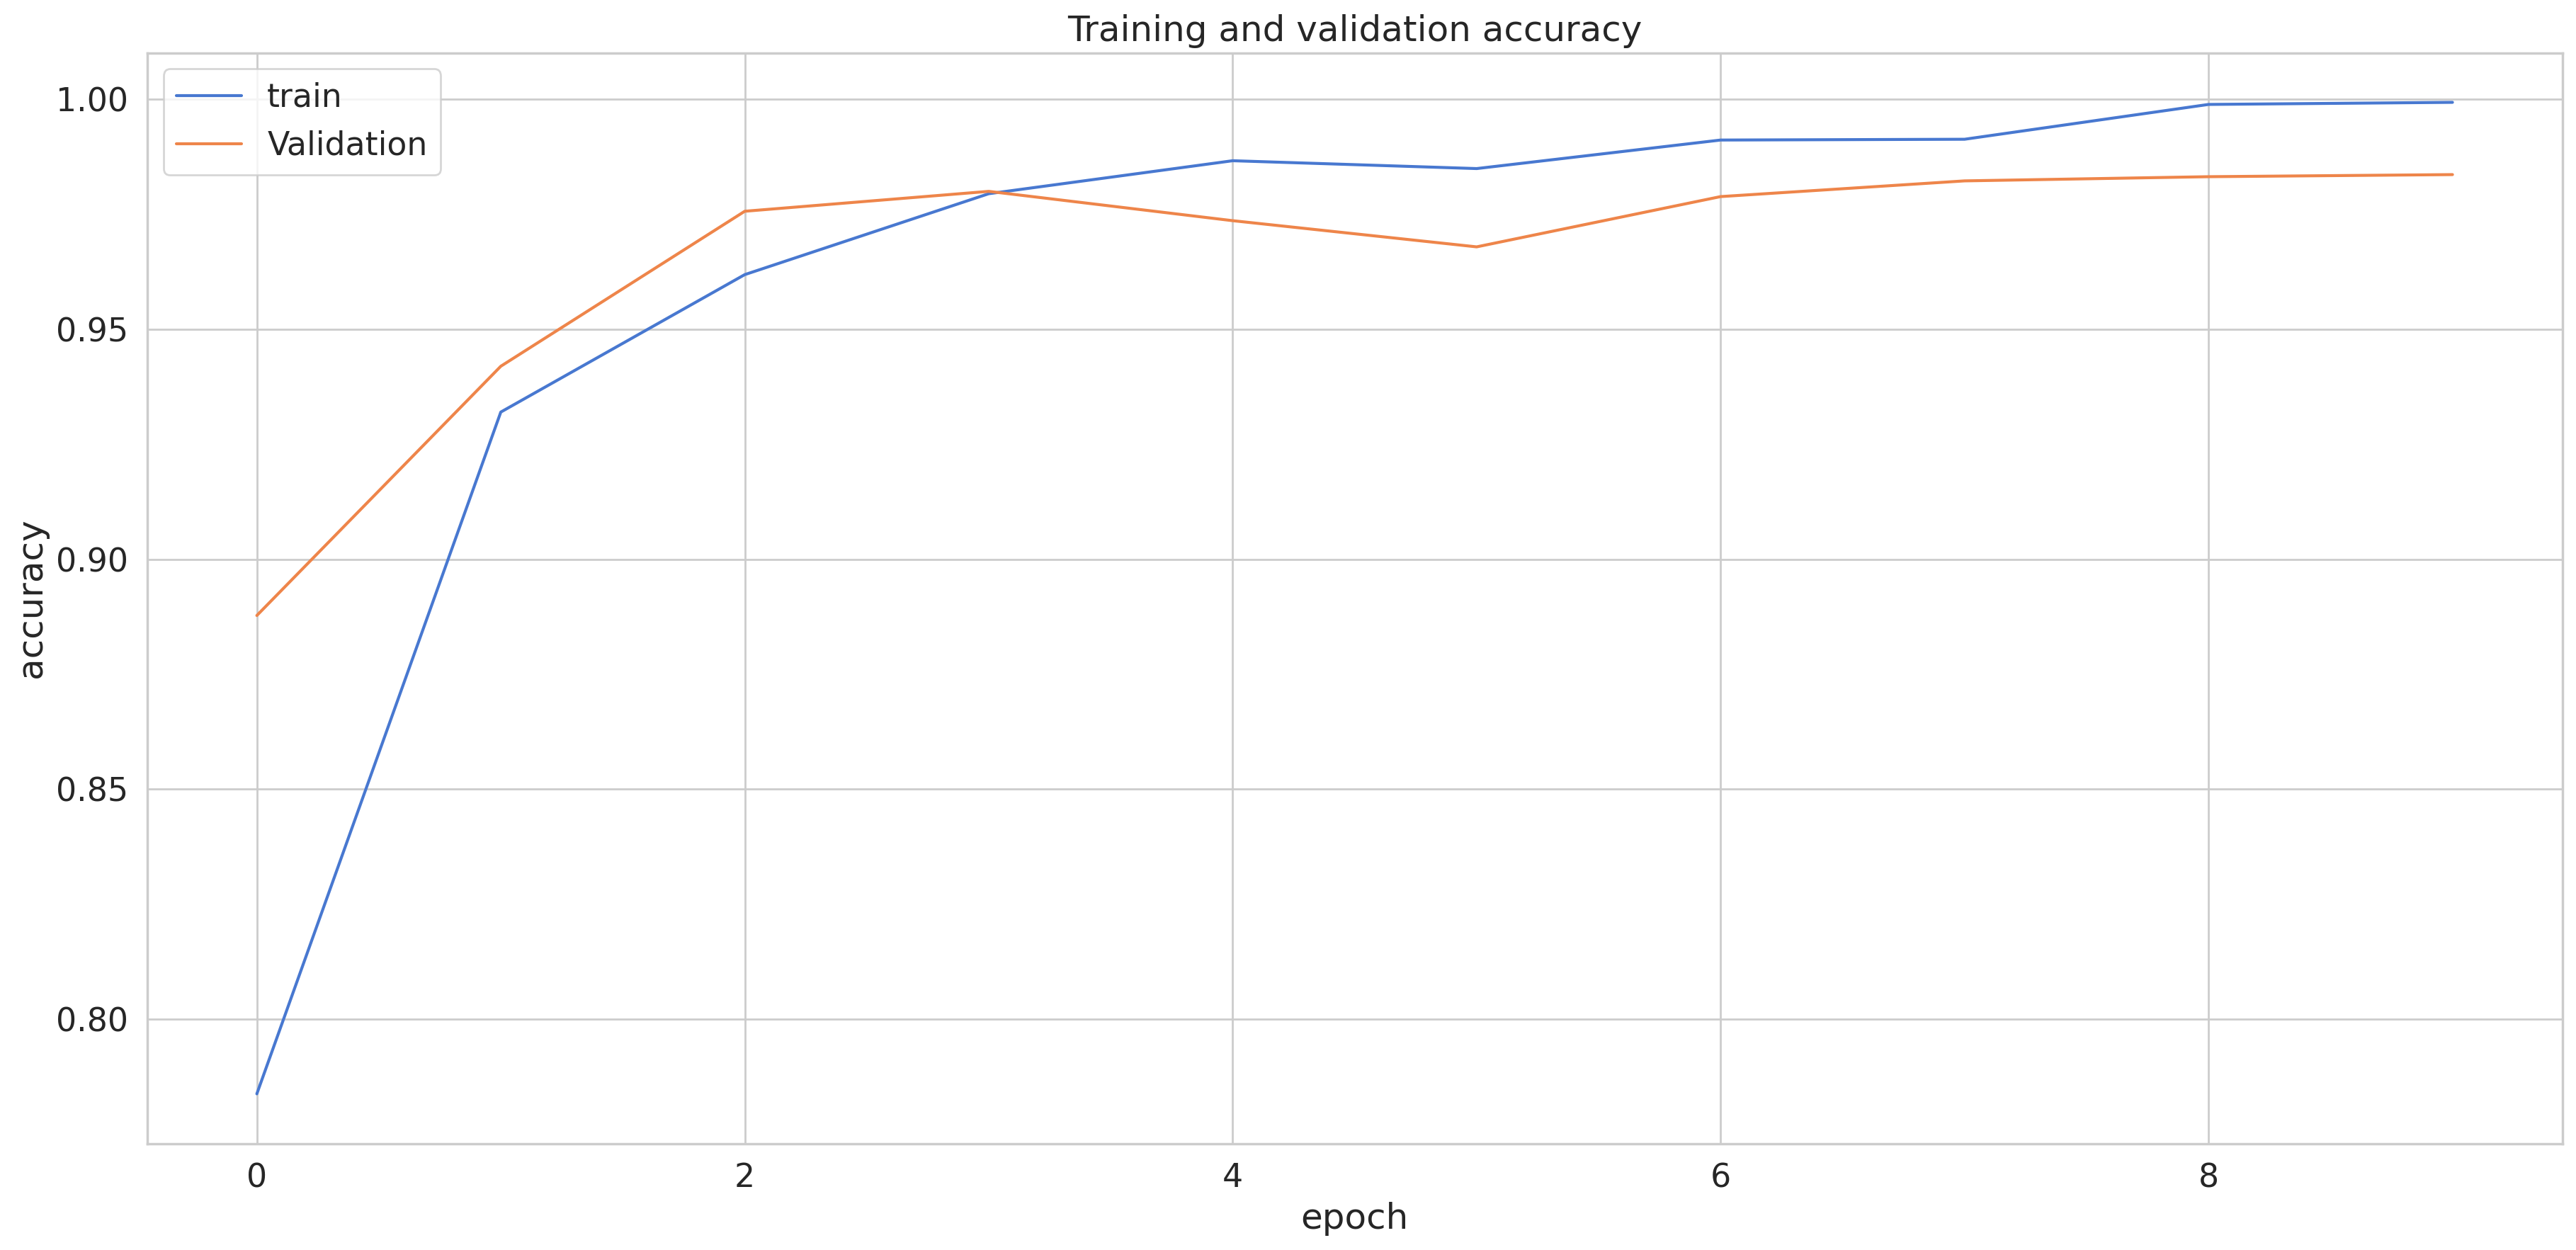

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 17ms/step
f1_score =  0.9797601536708855
0.9797851028956475
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2123
           1       1.00      0.99      0.99      1710
           2       0.93      0.93      0.93       614
           3       0.93      0.92      0.92       502
           4       0.99      1.00      1.00       300
           5       1.00      0.99      0.99       242

    accuracy                           0.98      5491
   macro avg       0.97      0.97      0.97      5491
weighted avg       0.98      0.98      0.98      5491



<Axes: >

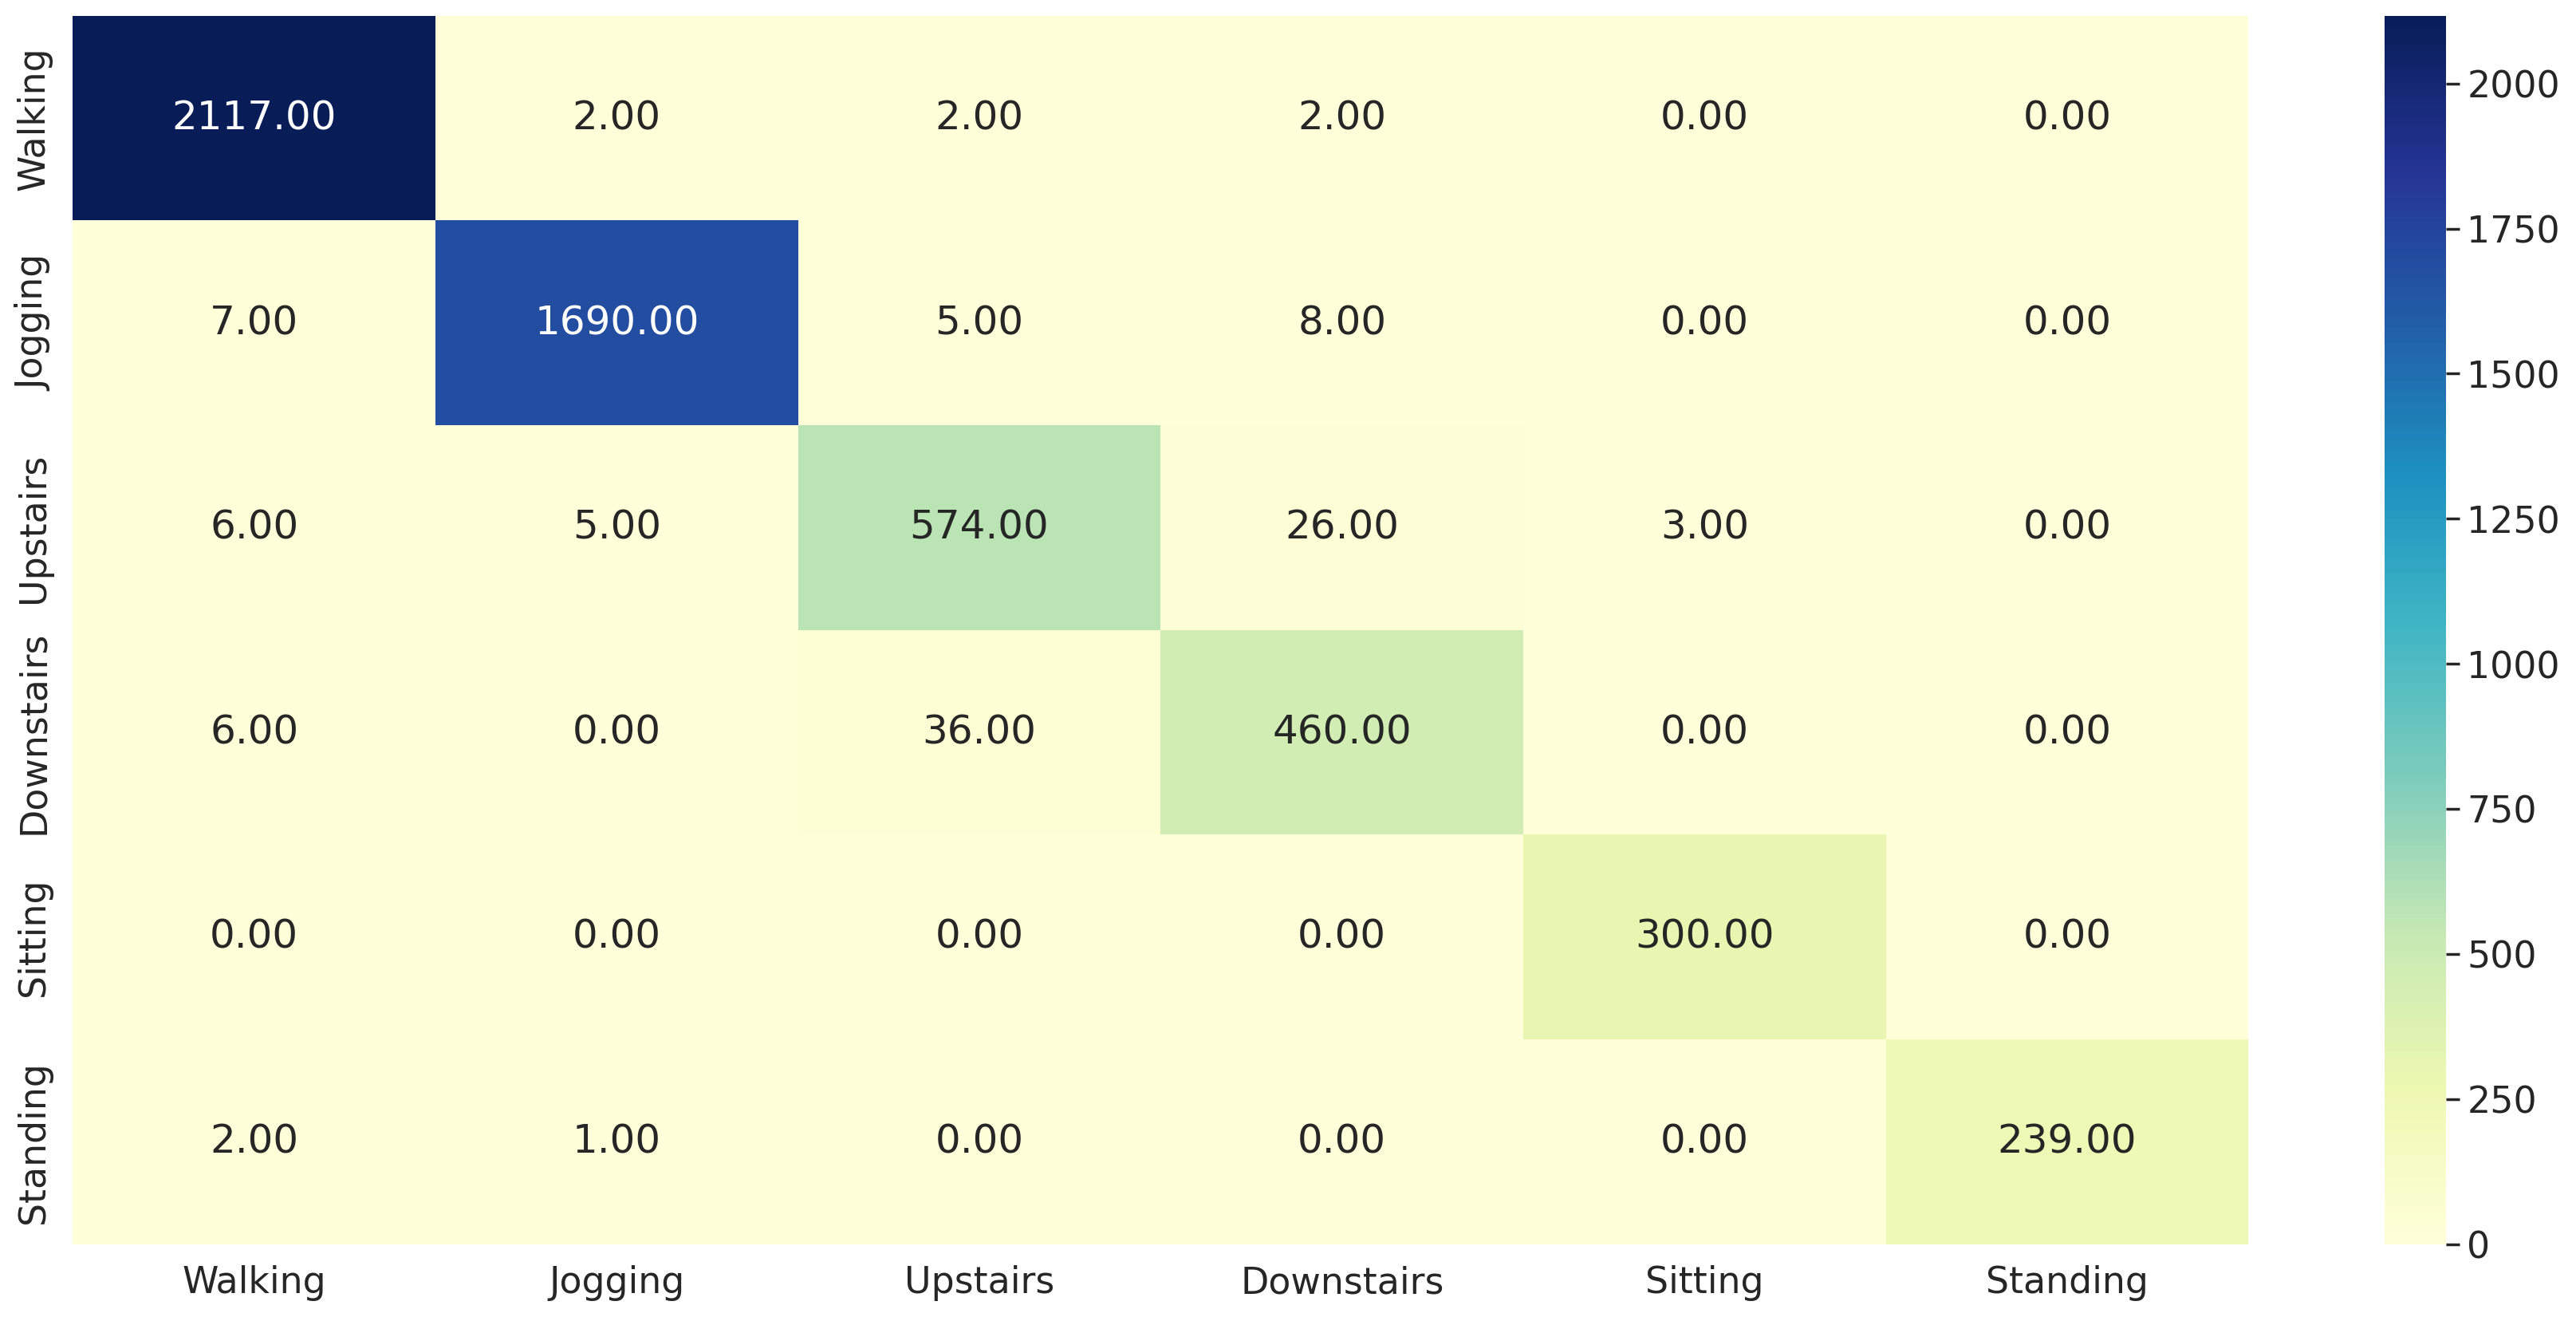

In [73]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')